<a href="https://colab.research.google.com/github/jardunn/ForTheBirds-EdenToAddo/blob/main/forTheBirds_E2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install Basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 460.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstall

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import json
import datetime

#For the birds: The influence of conservation corridors on bird conservation

#Eden to Addo Corridors¶

The area covered by the Eden to Addo Corridor is stored as a shape file. In this section we use the shape file to determine which pentads from SABAP2 are:

1. Contained: The for corners of the pentad fall within the corridor.
2. Overlap: Over 50% of the pentad falls within a [SADAP](https://egis.environment.gov.za/data_egis/data_download/current) protected area.
3. Neighbouring: None of the pentad corners fall witin the boundary but the pentad shares at least one side with an Overlapping pentad.



In [2]:
# Read in Eden to Addo Shape Files
e2a_shape_broad_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Broad_Corridors_12Feb2025.shp').to_crs(epsg=4326)
e2a_shape_site_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Sites_12Feb2025.shp')
e2a_shape_df = pd.concat([e2a_shape_broad_df, e2a_shape_site_df])
e2a_shape_df.shape

(14, 16)

In [3]:
# Read in SA Protected Areas Data (SAPAD): https://egis.environment.gov.za/data_egis/data_download/current
SAPAD_shape_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SAPAD_OR_2024_Q3/SAPAD_OR_2024_Q3.shp')
# Remove Noorsveld reserve to rather use the Eden to Addo site
SAPAD_shape_df = SAPAD_shape_df[SAPAD_shape_df.CUR_NME.apply(lambda x: 'Noorsveld' not in x)]
print(f'SAPAD Shape: {SAPAD_shape_df.shape}')


SAPAD Shape: (1663, 11)


In [4]:
# Read in Town Names
with open('/content/drive/MyDrive/ForTheBirds-E2A/SA_map/za.json', 'r') as f:
    town_names = json.load(f)
    f.close()

In [5]:
def inBounds(loc, lower_left, upper_right):
    #print(f'{loc}, ll: ${lower_left}, ur: ${upper_right}')
    return (lower_left[0] <= loc[1] <= upper_right[0]) and (lower_left[1] <= loc[0] <= upper_right[1])

def annotate(text, lat, lon):
    x, y = m(lon, lat)
    plt.text(x, y, text)

def addPlaceNames(places, lower_left, upper_right, population_threshold=None):
    places = [pt for pt in town_names if inBounds((float(pt.get('lat')), float(pt.get('lng'))), lower_left, upper_right)]
    if (population_threshold is not None):
        places = [pt for pt in places if int(pt.get('population', '0')) > population_threshold]
    for place in places:
        annotate(place.get('city'), float(place.get('lat')), float(place.get('lng')))

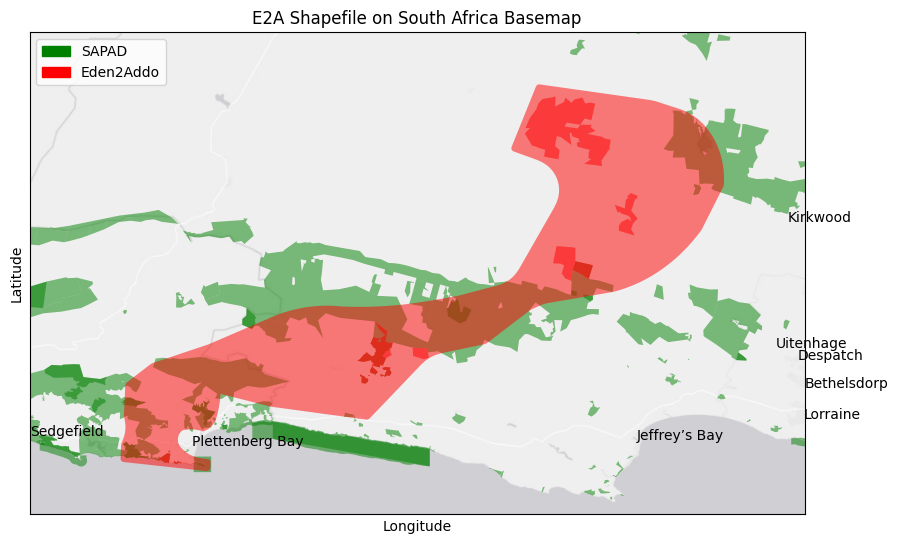

In [6]:
import numpy as np
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

# Assuming e2a_shape_df is already defined as in your previous code

# Define the bounds of South Africa (adjust if needed)
min_lon, min_lat = 22.8, -34.25#20, -34.25#23, -34.25 # approximate min longitude and latitude for South Africa
max_lon, max_lat = 25.5, -32.85#30, -20#25.25, -32.95 # approximate max longitude and latitude for South Africa

# Create the basemap
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Add coastlines and other map features
#m.drawcoastlines()
#m.drawcountries()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents()

# Plot the e2a_shape_df data on the basemap
SAPAD_shape_df.plot(ax=ax, color='green', alpha=0.5) # Plot the shapefile
e2a_shape_df.plot(ax=ax, color='red', alpha=0.5) # Plot the shapefile
#pentad_gdf[pentad_gdf.pentad == '3355_2350'].plot(ax=ax, color='blue')
#pentad_gdf[pentad_gdf.pentad == '3400_2350'].plot(ax=ax, color='orange')

addPlaceNames(town_names, (min_lon, min_lat), (max_lon, max_lat))

# Add a title and labels
plt.title('E2A Shapefile on South Africa Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='SAPAD')
red_patch = mpatches.Patch(color='red', label='Eden2Addo')
plt.legend(handles=[green_patch, red_patch], loc='upper left')

plt.show()


## Classify Pentads
We want to classify our pentads by first looking at where the corner points lie relative to the border of the borader corridor.

This can be done using the `contains` and `overlaps` Geopandas methods.

In [7]:
# Read in SABAP2 Pentad GeoJson
pentad_gdf = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/SABAP2_geojson.json')
pentad_gdf = pentad_gdf.to_crs(epsg=4326)

In [8]:
pentad_gdf.head()

pentad  full protocol  full protocol_total_hours  adhoc protocol  \
0  0825_3025              1                          5               0   
1  0900_2900              1                          3               0   
2  0900_3125              1                          7               1   
3  0920_2840              2                          6               0   
4  0930_2840              1                          3               0   

   incidental  additional information  2007  2008  2009  2010  ...  2018  \
0           0                       0     0     0     0     0  ...     0   
1           0                       0     0     0     0     0  ...     0   
2           0                       0     0     0     0     0  ...     0   
3           0                       0     0     0     0     0  ...     0   
4           0                       0     0     0     0     0  ...     0   

   2019  2020  2021  2022  2023  2024  2025   format  \
0     0     0     0     0     0     1     0  geoJSON   
1     1     0     0     0     0     0     0  geoJSON   
2     0     0     0     0     1     0     0  geoJSON   
3     1     0     1     0     0     0     0  geoJSON   
4     1     0     0     0     0     0     0  geoJSON   

                                            geometry  
0  MULTIPOLYGON (((30.4167 -8.41667, 30.50003 -8....  
1  MULTIPOLYGON (((29 -9, 29.08333 -9, 29.08333 -...  
2  MULTIPOLYGON (((31.4167 -9, 31.50003 -9, 31.50...  
3  MULTIPOLYGON (((28.6667 -9.33333, 28.75003 -9....  
4  MULTIPOLYGON (((28.6667 -9.5, 28.75003 -9.5, 2...  

[5 rows x 27 columns]

In [9]:
# Decrease shapes to consider by filtering to coarse bounding box
def filter_to_bounding_box(df, bounding_box):
    return df[df.geometry.apply(lambda row: (bounding_box.contains(row) or bounding_box.overlaps(row)))]

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
e2a_SAPAD_df = filter_to_bounding_box(SAPAD_shape_df, bounding_box)
e2a_pentad_gdf = filter_to_bounding_box(pentad_gdf, bounding_box)
corridor_boundary = e2a_shape_broad_df.geometry.iloc[0]

# Create a single area of SAPAD data
e2a_SAPAD_area = e2a_SAPAD_df.dissolve()
# Create a single area of the Eden to Addo sites
e2a_site_area = e2a_shape_site_df.dissolve()

In [10]:
# Classify Pentads
def classify_pentad(pentad_geometry, corridor_boundary, protected_areas):
  '''
  Classify SABAP2 pentads according in relation to the E2A corridor
  '''
  if corridor_boundary.contains(pentad_geometry):
    return 'contained'
  elif corridor_boundary.overlaps(pentad_geometry):
    return 'overlapping'
  else:
    return 'external'

def inc_coordinate(coord, value):
  seconds = int(coord[2:])
  minutes = int(coord[:2])
  new_seconds = seconds + value

  if new_seconds < 0:
    minutes -= 1
  elif seconds + value >= 60:
    minutes += 1
  return f'{minutes}{new_seconds % 60:02d}'

def is_neighbour(pentad_row, pentad_df):
  if pentad_row.corridor_status != 'external':
    return False
  pentad_name = pentad_row.pentad
  lat, lon = pentad_name.split('_')
  # Names for pentads to the North, South, East and West
  adjacent_pentad_names = [
      f'{inc_coordinate(lat, 5)}_{lon}',
      f'{inc_coordinate(lat, -5)}_{lon}',
      f'{lat}_{inc_coordinate(lon, 5)}',
      f'{lat}_{inc_coordinate(lon, -5)}'
  ]

  # Check adjacent pentads
  for adjacent_pentad_name in adjacent_pentad_names:
    adjacent_pentad = pentad_df[pentad_df.pentad == adjacent_pentad_name]
    # Check if the adjacent pentad exists and the corridor status if it exists.
    if adjacent_pentad.shape[0] > 0 and (adjacent_pentad.iloc[0].corridor_status == 'contained' or adjacent_pentad.iloc[0].corridor_status == 'overlapping'):
      return True
  return False

# First Pass: Classify as Internal, Overlapping, or External
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_pentad(row, corridor_boundary, e2a_SAPAD_df))
# Second Pass: Classify as Neighbouring if adjacent to an Internal or Overlapping Pentad
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.apply(lambda row: 'neighbouring' if is_neighbour(row, e2a_pentad_gdf) else row.corridor_status, axis=1)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


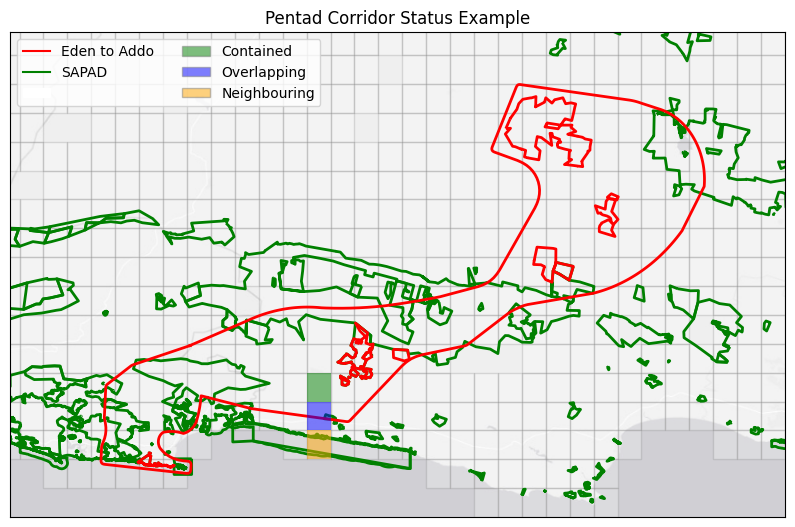

In [11]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbouring':
    return 'orange'
  else:
    return 'grey'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
#e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_pentad_gdf.plot(ax=ax, color='white', edgecolor='grey', alpha=0.25)

e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile
pentad_gdf[pentad_gdf.pentad == '3350_2350'].plot(ax=ax, color='green', alpha=0.5)
pentad_gdf[pentad_gdf.pentad == '3355_2350'].plot(ax=ax, color='blue', alpha=0.5)
pentad_gdf[pentad_gdf.pentad == '3400_2350'].plot(ax=ax, color='orange', alpha=0.5)

# Add a title and labels
plt.title('Pentad Corridor Status Example')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden to Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Contained', alpha=0.5)
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='Overlapping', alpha=0.5)
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.5, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='white', label='')
hatch_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='/...', alpha=0.5, label='Protected')
legend_elements = [red_line, green_line, white_patch, green_patch, blue_patch, orange_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


## Add Protected Area to Pentads
Use SAPAD regions to mark pentads as protected if they intersect with a protected area.

In [12]:
'''
def classify_protected(pentad_geometry, protected_areas):
  for area in protected_areas:
    if area.overlaps(pentad_geometry).any() or area.contains(pentad_geometry).any():
      return True
  return False

e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_protected(row, [e2a_SAPAD_df, e2a_shape_site_df]))
'''
PROTECTED_THRESHOLD = 0.5
e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(
    lambda polygon: (polygon.intersection(e2a_SAPAD_area.geometry.iloc[0]).area + polygon.intersection(e2a_site_area.geometry.loc[0]).area) / polygon.area > PROTECTED_THRESHOLD
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


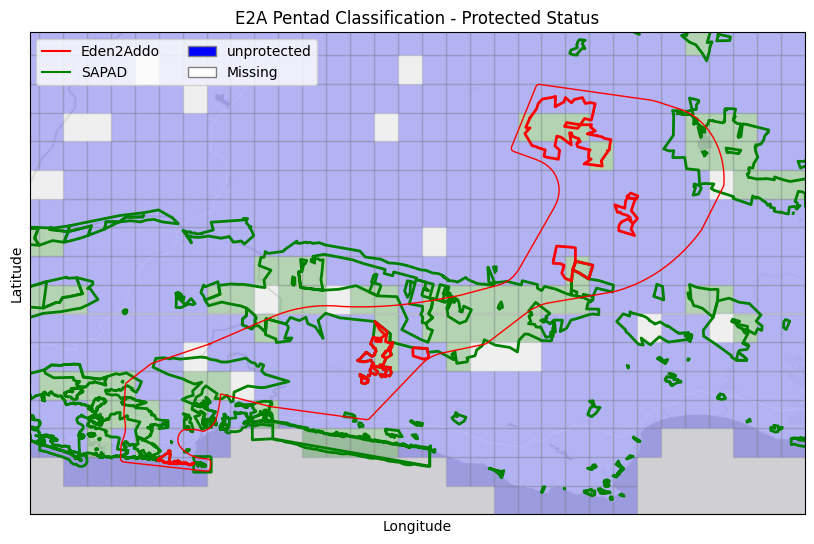

In [13]:
def protected_colour(protected):
  return 'green' if protected else 'blue'

def protected_percentage(percentage, threshold=0.9):
  return 'green' if percentage > threshold else 'blue'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.protected.apply(protected_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_site_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile
e2a_shape_broad_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=1) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Protected Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Protected')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='unprotected')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

# Pentad Statistics

In [14]:
e2a_with_external = e2a_pentad_gdf.copy()
e2a_pentad_gdf = e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external']

In [15]:
e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})

<ipython-input-15-1010d76bf171>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})


pentad  full protocol
corridor_status                       
contained            55            605
neighbouring         52           1659
overlapping          78           2608

In [16]:
e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})

<ipython-input-16-e0b18bb4fdbb>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})


pentad  full protocol
protected                       
False         135           3147
True           50           1725

In [17]:
def create_matrix(feature, aggregate_function):
  matrix_data = []

  for protected_status in e2a_pentad_gdf['protected'].unique():
    row = []
    for corridor_status in e2a_pentad_gdf['corridor_status'].unique():
      subset = e2a_pentad_gdf[(e2a_pentad_gdf['protected'] == protected_status) & (e2a_pentad_gdf['corridor_status'] == corridor_status)]
      full_protocol_sum = subset[feature].apply(aggregate_function)
      row.append(full_protocol_sum)
    matrix_data.append(row)

  # Create a DataFrame from the matrix
  matrix_df = pd.DataFrame(matrix_data, index=e2a_pentad_gdf['protected'].unique(), columns=e2a_pentad_gdf['corridor_status'].unique())
  row_totals = matrix_df.sum(axis=1)
  col_totals = matrix_df.sum(axis=0)

  # Add row totals as a new column
  matrix_df['Total'] = row_totals

  # Add column totals as a new row
  matrix_df.loc['Total'] = col_totals

  return matrix_df

print(create_matrix('full protocol', 'sum'))
print(create_matrix('pentad', 'count'))

       neighbouring  overlapping  contained   Total
False         414.0       2415.0      318.0  3147.0
True         1245.0        193.0      287.0  1725.0
Total        1659.0       2608.0      605.0     NaN
       neighbouring  overlapping  contained  Total
False          39.0         54.0       42.0  135.0
True           13.0         24.0       13.0   50.0
Total          52.0         78.0       55.0    NaN


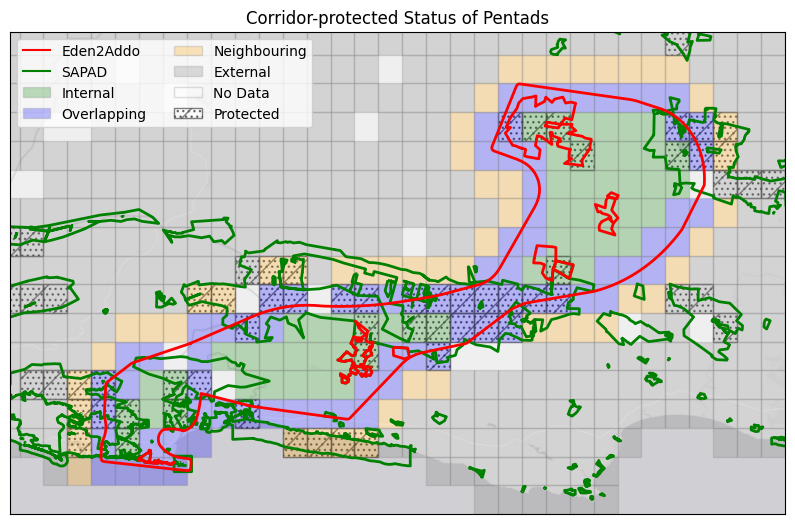

In [18]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbouring':
    return 'orange'
  else:
    return 'grey'


fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
# Potected
#e2a_with_external[e2a_with_external.percentage_protected > 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected > 0.5].apply(corridor_colour), hatch='/...', edgecolor='grey', alpha=0.25)
#e2a_with_external[e2a_with_external.percentage_protected <= 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected <= 0.5].apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_with_external[e2a_with_external.protected].plot(ax=ax, facecolor='none', hatch='/...', edgecolor='black', alpha=0.5)
e2a_with_external.plot(ax=ax, color=e2a_with_external.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_area.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('Corridor-protected Status of Pentads')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', alpha=0.25, label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', alpha=0.25, label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', alpha=0.25, label='No Data')
hatch_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='/...', alpha=0.5, label='Protected')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch, hatch_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

## Get Data from SABAP2
Using the bird map API we will access the species lists for each of the pentads.

In [19]:
# Get list of pentads
pentads = e2a_pentad_gdf.pentad[e2a_pentad_gdf.corridor_status.isin(['contained', 'overlapping', 'neighbouring'])].unique()
print(f'Collected {len(pentads)} pentads')


Collected 185 pentads


In [20]:
import requests
from io import StringIO

def getPentadSpeciesList(pentad):
  response = requests.get(f'https://api.birdmap.africa/sabap2/v2/coverage/pentad/{pentad}/species?format=csv')
  pentad_species = pd.read_csv(StringIO(response.text))
  pentad_species['scientific_name'] = pentad_species.apply(lambda row: row.Genus +' '+ row.Species, axis =1 )
  pentad_species['common_name'] = pentad_species.apply(lambda row: (row.Common_species + ' ' +row.Common_group)  if pd.notna(row.Common_group) else row.Common_species, axis = 1)
  pentad_species['pentad'] = pentad
  return pentad_species.drop(columns=['Genus', 'Species', 'Common_species'])



In [21]:
'''
start = datetime.datetime.now()
pentad_species = getPentadSpeciesList(pentads[0])
for pentad in pentads[1:]:
  pentad_species = pd.concat([pentad_species, getPentadSpeciesList(pentad)])
end = datetime.datetime.now()

print(f'Collected from {start} UTC to {end} UTC - {end - start}')
pentad_species.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv')
'''
#Collected from 2025-02-26 05:08:25.960909 UTC to 2025-02-26 05:11:37.917132 UTC - 0:03:11.956223


"\nstart = datetime.datetime.now()\npentad_species = getPentadSpeciesList(pentads[0])\nfor pentad in pentads[1:]:\n  pentad_species = pd.concat([pentad_species, getPentadSpeciesList(pentad)])\nend = datetime.datetime.now()\n\nprint(f'Collected from {start} UTC to {end} UTC - {end - start}')\npentad_species.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv')\n"

In [22]:
sabap2_pentad_species = pd.read_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv', index_col=0)


In [23]:
sabap2_pentad_species.head()

Ref Common_group     fp  fpn     fp_last   ad  adn ad_last  \
0  637          NaN  100.0    1  2014-01-23  0.0    0       -   
1  622       Apalis  100.0    1  2014-01-23  0.0    0       -   
2  432       Barbet  100.0    1  2014-01-23  0.0    0       -   
3  674        Batis  100.0    1  2014-01-23  0.0    0       -   
4  874      Bunting  100.0    1  2014-01-23  0.0    0       -   

          scientific_name              common_name     pentad  
0  Cisticola fulvicapilla                 Neddicky  3255_2430  
1        Apalis thoracica      Bar-throated Apalis  3255_2430  
2  Tricholaema leucomelas       Acacia Pied Barbet  3255_2430  
3            Batis pririt             Pririt Batis  3255_2430  
4   Emberiza flaviventris  Golden-breasted Bunting  3255_2430

# Read in SABAP2 Data
GBIF.org (19 February 2025) GBIF Occurrence Download https://doi.org/10.15468/dl.gjy4d4

The data is only for the region around the bounded area and includes all records.

In [ ]:
from shapely.geometry import mapping, Polygon
geojson_data = {
    "type": "Feature",
    "geometry": mapping(bounding_box),
    "properties": {}  # You can add properties here if needed
}

# Print the GeoJSON this can be used to extract data from GBIF
print(json.dumps(geojson_data, indent=2))

{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          22.8,
          -34.25
        ],
        [
          25.5,
          -34.25
        ],
        [
          25.5,
          -32.85
        ],
        [
          22.8,
          -32.85
        ],
        [
          22.8,
          -34.25
        ]
      ]
    ]
  },
  "properties": {}
}


In [ ]:
sabap_raw_df = pd.read_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/occurrence.txt', sep='\t').dropna(axis=1, how='all').drop(
    columns=['institutionID', 'institutionCode', 'collectionID', 'datasetName', 'ownerInstitutionCode', 'occurrenceID'])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import re
sabap_raw_df['hours_observing'] = sabap_raw_df.occurrenceRemarks.apply(lambda x: int(re.findall(r'\d+', x)[0]))
print(f'SABAP raw DF shape: {sabap_raw_df.shape}')

In [ ]:
sabap_df = sabap_raw_df[['verbatimLocality', 'identificationRemarks', 'year', 'month', 'day', 'speciesKey', 'species', 'acceptedScientificName',
       'lastCrawled', 'repatriated', 'fieldNotes', 'hours_observing',
       'isSequenced', 'gbifRegion', 'publishedByGbifRegion', 'level0Gid',
       'level0Name', 'level1Gid', 'level1Name', 'level2Gid', 'level2Name',
       'level3Gid', 'level3Name', 'iucnRedListCategory']].rename(
           columns={
           'verbatimLocality': 'pentad',
           'fieldNotes': 'cardId'
           }
       )

In [ ]:
sabap_df = sabap_df[sabap_df.hours_observing > 1]
print(f'SABAP DF more than 2+ hours shape: {sabap_df.shape}')

# Merge SABAP2 Data with Pentad Data
Add the `corridor status` and `protected status` to the SABAP2 species data.

In [24]:
# Merge the dataframes
sabap_df = pd.merge(sabap2_pentad_species, e2a_pentad_gdf[['pentad', 'corridor_status', 'protected']], on='pentad', how='left')

In [25]:
sabap_df.head()

Ref Common_group     fp  fpn     fp_last   ad  adn ad_last  \
0  637          NaN  100.0    1  2014-01-23  0.0    0       -   
1  622       Apalis  100.0    1  2014-01-23  0.0    0       -   
2  432       Barbet  100.0    1  2014-01-23  0.0    0       -   
3  674        Batis  100.0    1  2014-01-23  0.0    0       -   
4  874      Bunting  100.0    1  2014-01-23  0.0    0       -   

          scientific_name              common_name     pentad corridor_status  \
0  Cisticola fulvicapilla                 Neddicky  3255_2430    neighbouring   
1        Apalis thoracica      Bar-throated Apalis  3255_2430    neighbouring   
2  Tricholaema leucomelas       Acacia Pied Barbet  3255_2430    neighbouring   
3            Batis pririt             Pririt Batis  3255_2430    neighbouring   
4   Emberiza flaviventris  Golden-breasted Bunting  3255_2430    neighbouring   

   protected  
0      False  
1      False  
2      False  
3      False  
4      False

In [26]:
sabap_df.corridor_status.value_counts()

corridor_status
overlapping     7650
neighbouring    5327
contained       4272
Name: count, dtype: int64

In [27]:
corridor_species_list = sabap_df.groupby(['common_name', 'corridor_status', 'protected']).agg({'pentad': 'count'}).reset_index()\
.rename(columns={'pentad': 'count'})
corridor_species_list['pretected'] = corridor_species_list['protected'].apply(lambda p: 'Protected' if p else 'Unprotected')
corridor_species_list = corridor_species_list.pivot(index='common_name', columns=['corridor_status', 'protected'], values='count').fillna(0)
corridor_species_list.columns = [f'{col[0].capitalize()}-{"Protected" if col[1] else "Unprotected"}' for col in corridor_species_list.columns]
corridor_species_list.reset_index(inplace=True)
corridor_species_list['total'] = corridor_species_list.drop(columns=['common_name']).sum(axis=1)
sabap_species_list = corridor_species_list.sort_values('total', ascending=False)
#corridor_species_list.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/corridor_species_list.csv')
sabap_species_list.head()

common_name  Contained-Unprotected  Contained-Protected  \
282             Neddicky                   40.0                 12.0   
229         Karoo Prinia                   40.0                  9.0   
329     Ring-necked Dove                   38.0                 10.0   
47   Bar-throated Apalis                   37.0                 10.0   
104      Cape Robin-Chat                   34.0                 11.0   

     Neighbouring-Unprotected  Neighbouring-Protected  \
282                      38.0                    11.0   
229                      38.0                    13.0   
329                      37.0                    13.0   
47                       35.0                    11.0   
104                      32.0                    12.0   

     Overlapping-Unprotected  Overlapping-Protected  total  
282                     53.0                   21.0  175.0  
229                     53.0                   21.0  174.0  
329                     52.0                   22.0  172.0  
47                      52.0                   22.0  167.0  
104                     50.0                   21.0  160.0

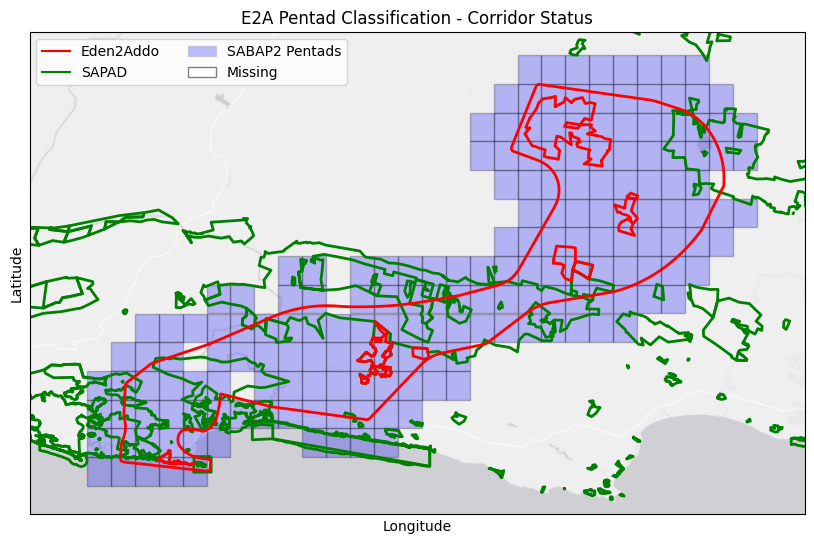

In [28]:
sabap_pentads = pentad_gdf[pentad_gdf.pentad.isin(sabap_df.pentad.unique())]

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
sabap_pentads.plot(ax=ax, color='blue', edgecolor='black', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Corridor Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='SABAP2 Pentads')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


In [29]:
sabap_plot_df = pd.merge(sabap_pentads, sabap_df, how='left', on='pentad')[['pentad', 'corridor_status', 'protected', 'geometry']].drop_duplicates()

In [30]:
sabap_plot_df.shape

(185, 4)

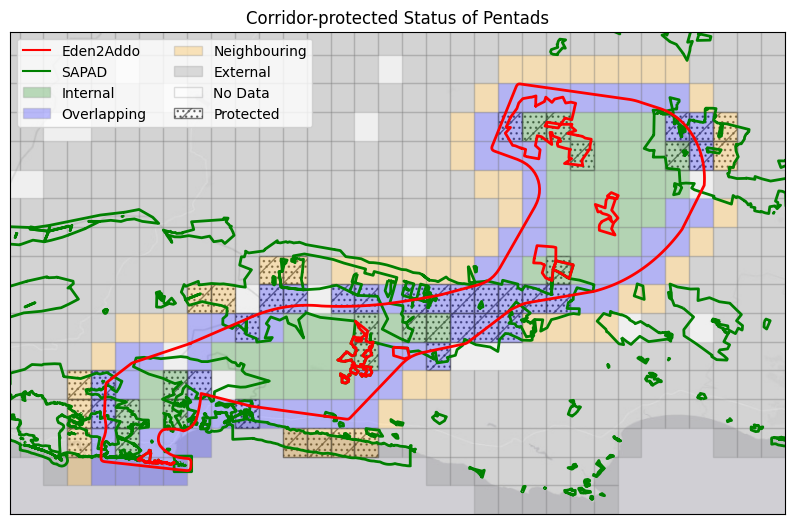

In [31]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbouring':
    return 'orange'
  else:
    return 'grey'


fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
# Potected
#e2a_with_external[e2a_with_external.percentage_protected > 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected > 0.5].apply(corridor_colour), hatch='/...', edgecolor='grey', alpha=0.25)
#e2a_with_external[e2a_with_external.percentage_protected <= 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected <= 0.5].apply(corridor_colour), edgecolor='grey', alpha=0.25)
sabap_plot_df[sabap_plot_df.protected].plot(ax=ax, facecolor='none', hatch='/...', edgecolor='black', alpha=0.5)
e2a_with_external.plot(ax=ax, color=e2a_with_external.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_area.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('Corridor-protected Status of Pentads')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', alpha=0.25, label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', alpha=0.25, label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', alpha=0.25, label='No Data')
hatch_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='/...', alpha=0.5, label='Protected')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch, hatch_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

In [32]:
common_name_df = sabap_df[['scientific_name', 'common_name']].drop_duplicates()

def getCommonName(species):
  return common_name_df[common_name_df.scientific_name == species].common_name.values[0]

getCommonName('Apalis thoracica')

'Bar-throated Apalis'

## Read in Habitat data

In [33]:
def get_group_species(group):
  group_df = pd.read_excel('/content/drive/MyDrive/ForTheBirds-E2A/corridor_species_list_habitats.xlsx', sheet_name=group)
  return group_df.scientific_name.to_list()

In [34]:
groups = ['Common species', 'Fynbos', 'Forest', 'Raptors', 'Coastal & Waterbirds', 'Karoo', 'IUCN']
for group in groups:
  sabap_df[group] = sabap_df.scientific_name.isin(get_group_species(group))
sabap_df.head()

Ref Common_group     fp  fpn     fp_last   ad  adn ad_last  \
0  637          NaN  100.0    1  2014-01-23  0.0    0       -   
1  622       Apalis  100.0    1  2014-01-23  0.0    0       -   
2  432       Barbet  100.0    1  2014-01-23  0.0    0       -   
3  674        Batis  100.0    1  2014-01-23  0.0    0       -   
4  874      Bunting  100.0    1  2014-01-23  0.0    0       -   

          scientific_name              common_name     pentad corridor_status  \
0  Cisticola fulvicapilla                 Neddicky  3255_2430    neighbouring   
1        Apalis thoracica      Bar-throated Apalis  3255_2430    neighbouring   
2  Tricholaema leucomelas       Acacia Pied Barbet  3255_2430    neighbouring   
3            Batis pririt             Pririt Batis  3255_2430    neighbouring   
4   Emberiza flaviventris  Golden-breasted Bunting  3255_2430    neighbouring   

   protected  Common species  Fynbos  Forest  Raptors  Coastal & Waterbirds  \
0      False            True   False   False    False                 False   
1      False            True   False    True    False                 False   
2      False           False   False   False    False                 False   
3      False           False   False   False    False                 False   
4      False           False   False   False    False                 False   

   Karoo   IUCN  
0  False  False  
1  False  False  
2   True  False  
3   True  False  
4  False  False

In [35]:
def get_species_for_group(groups, attribute='scientific_name'):
  return [val.lower() for val in sabap_df[sabap_df[groups].all(axis=1)][attribute].unique()]
get_species_for_group(['Common species'])

['cisticola fulvicapilla',
 'apalis thoracica',
 'streptopelia capicola',
 'dicrurus adsimilis',
 'lanius collaris',
 'prinia maculosa',
 'corvus albicollis',
 'laniarius ferrugineus',
 'pycnonotus capensis',
 'streptopelia semitorquata',
 'melaenornis silens',
 'alopochen aegyptiaca',
 'bostrychia hagedash',
 'colius striatus',
 'cossypha caffra',
 'cinnyris chalybeus',
 'motacilla capensis',
 'zosterops virens',
 'andropadus importunus',
 'onychognathus morio',
 'chalcomitra amethystina',
 'batis capensis',
 'cinnyris afer',
 'ploceus capensis',
 'oriolus larvatus',
 'tauraco corythaix']

## Calculate Reporting Rate
Display the reporting rate for full protocol cards `fp` this is calculated as $\text{Reporting Rate} = \frac{\text{Number  of Species Records}}{\text{Number of Cards}}$

In [36]:
sabap_df['fp_num_cards'] = sabap_df.apply(lambda row: row.fpn / (row.fp / 100) if row.fp else np.nan, axis=1)
sabap_df.head()

Ref Common_group     fp  fpn     fp_last   ad  adn ad_last  \
0  637          NaN  100.0    1  2014-01-23  0.0    0       -   
1  622       Apalis  100.0    1  2014-01-23  0.0    0       -   
2  432       Barbet  100.0    1  2014-01-23  0.0    0       -   
3  674        Batis  100.0    1  2014-01-23  0.0    0       -   
4  874      Bunting  100.0    1  2014-01-23  0.0    0       -   

          scientific_name              common_name  ... corridor_status  \
0  Cisticola fulvicapilla                 Neddicky  ...    neighbouring   
1        Apalis thoracica      Bar-throated Apalis  ...    neighbouring   
2  Tricholaema leucomelas       Acacia Pied Barbet  ...    neighbouring   
3            Batis pririt             Pririt Batis  ...    neighbouring   
4   Emberiza flaviventris  Golden-breasted Bunting  ...    neighbouring   

  protected  Common species  Fynbos  Forest  Raptors  Coastal & Waterbirds  \
0     False            True   False   False    False                 False   
1     False            True   False    True    False                 False   
2     False           False   False   False    False                 False   
3     False           False   False   False    False                 False   
4     False           False   False   False    False                 False   

   Karoo   IUCN  fp_num_cards  
0  False  False           1.0  
1  False  False           1.0  
2   True  False           1.0  
3   True  False           1.0  
4  False  False           1.0  

[5 rows x 21 columns]

In [37]:
sabap_df[(pd.isna(sabap_df.fp_num_cards)) & (sabap_df.adn > 0)]

Ref Common_group   fp  fpn fp_last       ad  adn     ad_last  \
26      524        Raven  0.0    0       -  33.3333    1  2017-08-09   
31       85    Spoonbill  0.0    0       -  33.3333    1  2016-03-08   
63      523         Crow  0.0    0       -  12.5000    1  2013-08-24   
68      314         Dove  0.0    0       -  12.5000    1  2019-08-08   
71       95         Duck  0.0    0       -  12.5000    1  2017-09-29   
...     ...          ...  ...  ...     ...      ...  ...         ...   
17244  4137       Petrel  0.0    0       -  50.0000    1  2021-07-16   
17245    29   Shearwater  0.0    0       -  50.0000    1  2021-07-16   
17246   286         Skua  0.0    0       -  50.0000    1  2021-07-16   
17247    98         Teal  0.0    0       -  50.0000    1  2021-11-27   
17248   686      Wagtail  0.0    0       -  50.0000    1  2021-11-27   

                  scientific_name           common_name  ... corridor_status  \
26              Corvus albicollis    White-necked Raven  ...    neighbouring   
31                  Platalea alba     African Spoonbill  ...    neighbouring   
63                Corvus capensis             Cape Crow  ...    neighbouring   
68      Streptopelia semitorquata         Red-eyed Dove  ...    neighbouring   
71                    Anas sparsa    African Black Duck  ...    neighbouring   
...                           ...                   ...  ...             ...   
17244  Procellaria aequinoctialis  White-chinned Petrel  ...     overlapping   
17245              Ardenna grisea      Sooty Shearwater  ...     overlapping   
17246    Stercorarius antarcticus     Subantarctic Skua  ...     overlapping   
17247               Anas capensis             Cape Teal  ...     overlapping   
17248          Motacilla capensis          Cape Wagtail  ...     overlapping   

      protected  Common species  Fynbos  Forest  Raptors  \
26        False            True   False   False    False   
31        False           False   False   False    False   
63        False           False   False   False    False   
68        False            True   False   False    False   
71        False           False   False   False    False   
...         ...             ...     ...     ...      ...   
17244     False           False   False   False    False   
17245     False           False   False   False    False   
17246     False           False   False   False    False   
17247     False           False   False   False    False   
17248     False            True   False   False    False   

       Coastal & Waterbirds  Karoo   IUCN  fp_num_cards  
26                    False   True  False           NaN  
31                     True  False  False           NaN  
63                    False   True  False           NaN  
68                    False  False  False           NaN  
71                     True  False  False           NaN  
...                     ...    ...    ...           ...  
17244                  True  False   True           NaN  
17245                  True  False   True           NaN  
17246                  True  False  False           NaN  
17247                  True  False  False           NaN  
17248                 False  False  False           NaN  

[1382 rows x 21 columns]

In [38]:
# Aggregate card counts to remove rounding erros
card_count_df = sabap_df[['pentad', 'fp_num_cards']].dropna().groupby('pentad').agg('mean').reset_index()
card_count_df['fp_num_cards'] = card_count_df.fp_num_cards.apply(lambda x: np.round(x))
card_count_df.head()

pentad  fp_num_cards
0  3255_2430           1.0
1  3255_2435           6.0
2  3255_2440           5.0
3  3255_2445           5.0
4  3255_2450          10.0

In [39]:
def getPentadCardCount(pentad):
  card_count_values = card_count_df[card_count_df.pentad==pentad].fp_num_cards.values
  if len(card_count_values) > 0:
    return card_count_values[0]
  else:
    return 0
sabap_df['fp_num_cards'] = sabap_df.pentad.apply(lambda pentad: getPentadCardCount(pentad))

In [40]:
# get card cound by corridor_status and protected status
# Corridor status and protected to card count df
card_counts_by_status = pd.merge(card_count_df, e2a_pentad_gdf[['pentad', 'corridor_status', 'protected']], on='pentad', how='left').groupby(['corridor_status', 'protected']).agg({'pentad': 'nunique', 'fp_num_cards': 'sum'})

def getCardCountByStatus(corridor_status, protected_status):
  return card_counts_by_status.loc[(corridor_status, protected_status)].fp_num_cards

In [41]:
card_counts_by_status

pentad  fp_num_cards
corridor_status protected                      
contained       False          42         318.0
                True           10         289.0
neighbouring    False          39         415.0
                True           12        1249.0
overlapping     False          53        2427.0
                True           24         196.0

<Axes: >

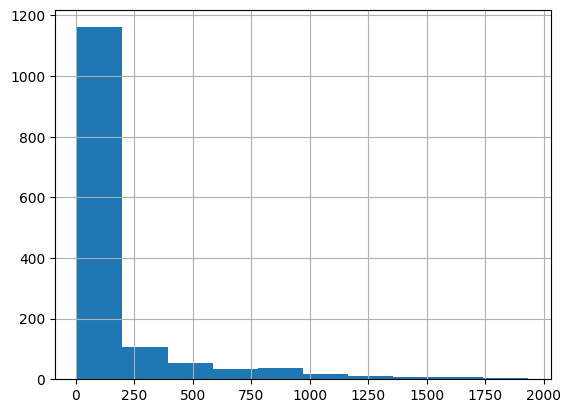

In [42]:
# Aggregate to corridor_stats and protected
sabap_rr_df = sabap_df.groupby(['scientific_name', 'corridor_status', 'protected']).agg({'fpn': 'sum'}).reset_index()
sabap_rr_df['fp_num_cards'] = sabap_rr_df.apply(lambda row: getCardCountByStatus(row.corridor_status, row.protected), axis=1)
sabap_rr_df['reporting_rate'] = sabap_rr_df.fpn / sabap_rr_df.fp_num_cards
sabap_rr_df = sabap_rr_df[sabap_rr_df.fpn > 5]
sabap_rr_df.fpn.hist()

## Selects species to be filtered out

In [43]:
filtered_sabap_df = sabap_df[sabap_df.scientific_name.isin(sabap_rr_df.scientific_name.unique())]
filtered_sabap_df.shape

(17077, 21)

In [44]:
filtered_sabap_df.groupby('corridor_status').agg({'pentad': 'nunique'})

pentad
corridor_status        
contained            55
neighbouring         52
overlapping          78

In [45]:
sabap_df[['scientific_name', 'common_name']].drop_duplicates()

scientific_name                  common_name
0        Cisticola fulvicapilla                     Neddicky
1              Apalis thoracica          Bar-throated Apalis
2        Tricholaema leucomelas           Acacia Pied Barbet
3                  Batis pririt                 Pririt Batis
4         Emberiza flaviventris      Golden-breasted Bunting
...                         ...                          ...
17029             Fregata ariel           Lesser Frigatebird
17071    Anastomus lamelligerus             African Openbill
17093         Eudyptes moseleyi  Northern Rockhopper Penguin
17100             Chionis albus             Snowy Sheathbill
17239  Thalassarche melanophris       Black-browed Albatross

[432 rows x 2 columns]

In [46]:
sabap_rr_species_list = sabap_rr_df.rename(columns={'fpn': 'count'}).pivot(index='scientific_name', columns=['corridor_status', 'protected'], values=['reporting_rate','count']).fillna(0)
sabap_rr_species_list.columns = [f'{"Internal" if col[0]=="contained" else col[0].capitalize()}-{"Protected" if col[1] else "Unprotected"}' for col in sabap_rr_species_list.columns]
sabap_rr_species_list.reset_index(inplace=True)
sabap_rr_species_list['reporting_rate_mean'] = sabap_rr_species_list.drop(columns=['scientific_name']).mean(axis=1)
sabap_rr_species_list['reporting_rate_stdev'] = sabap_rr_species_list.drop(columns=['scientific_name', 'reporting_rate_mean']).std(axis=1)
sabap_rr_species_list = sabap_rr_species_list.sort_values('reporting_rate_mean', ascending=False)
sabap_rr_species_list = pd.merge(sabap_rr_species_list, sabap_df[['scientific_name', 'common_name']].drop_duplicates(), how='left', on='scientific_name')
sabap_rr_species_list = sabap_rr_species_list[['common_name'] + sabap_rr_species_list.columns[:-1].to_list()]
#sabap_rr_species_list = sabap_rr_species_list[['common_name', 'scientific_name', 'Internal-Protected', 'Internal-Unprotected', 'Overlapping-Protected', 'Overlapping-Unprotected', 'Neighbour-Protected', 'Neighbour-Unprotected', 'reporting_rate_mean', 'reporting_rate_stdev']]
#sabap_rr_species_list.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/corridor_species_list.csv')
sabap_rr_species_list.head()


common_name        scientific_name  Reporting_rate-Protected  \
0     Sombre Greenbul  Andropadus importunus                  0.749398   
1      Cape White-eye       Zosterops virens                  0.592771   
2  Fork-tailed Drongo     Dicrurus adsimilis                  0.677108   
3    Ring-necked Dove  Streptopelia capicola                  0.850602   
4         Hadada Ibis    Bostrychia hagedash                  0.556627   

   Reporting_rate-Protected  Reporting_rate-Protected  \
0                  0.851882                  0.796457   
1                  0.845476                  0.736300   
2                  0.779824                  0.740008   
3                  0.716573                  0.715286   
4                  0.835068                  0.736712   

   Reporting_rate-Protected  Reporting_rate-Protected  \
0                  0.826531                  0.778547   
1                  0.816327                  0.698962   
2                  0.663265                  0.719723   
3                  0.602041                  0.681661   
4                  0.443878                  0.650519   

   Reporting_rate-Protected  Reporting_rate-Protected  \
0                  0.628931                  0.749398   
1                  0.393082                  0.592771   
2                  0.540881                  0.677108   
3                  0.710692                  0.850602   
4                  0.493711                  0.556627   

   Reporting_rate-Protected  ...  Count-Protected  Count-Protected  \
0                  0.851882  ...            225.0            200.0   
1                  0.845476  ...            202.0            125.0   
2                  0.779824  ...            208.0            172.0   
3                  0.716573  ...            197.0            226.0   
4                  0.835068  ...            188.0            157.0   

   Count-Protected  Count-Protected  Count-Protected  Count-Protected  \
0            311.0           1064.0           1933.0            162.0   
1            246.0           1056.0           1787.0            160.0   
2            281.0            974.0           1796.0            130.0   
3            353.0            895.0           1736.0            118.0   
4            231.0           1043.0           1788.0             87.0   

   Count-Protected  Count-Protected  reporting_rate_mean  reporting_rate_stdev  
0            225.0            200.0           324.969312            588.906379  
1            202.0            125.0           298.340243            554.565359  
2            208.0            172.0           297.093401            546.378989  
3            197.0            226.0           294.106405            522.681822  
4            188.0            157.0           291.476376            554.831398  

[5 rows x 76 columns]

## Pivot SABAP Reporting Rate Idex

In [47]:
def get_pivoted_sabap_rr_df():
  pivoted_sabap_rr_df = sabap_rr_df.copy()
  pivoted_sabap_rr_df['protected'] = pivoted_sabap_rr_df.protected.apply(lambda x: 'Protected' if x else 'Unprotected')

  pivoted_sabap_rr_df = pivoted_sabap_rr_df.pivot(index='scientific_name', columns=['corridor_status', 'protected'], values='reporting_rate')\
      .reset_index()\
      .fillna(0)
  pivoted_sabap_rr_df.columns = ['-'.join(col).strip('-') for col in pivoted_sabap_rr_df.columns]
  return pivoted_sabap_rr_df

## Species Count per Pentad

<Axes: >

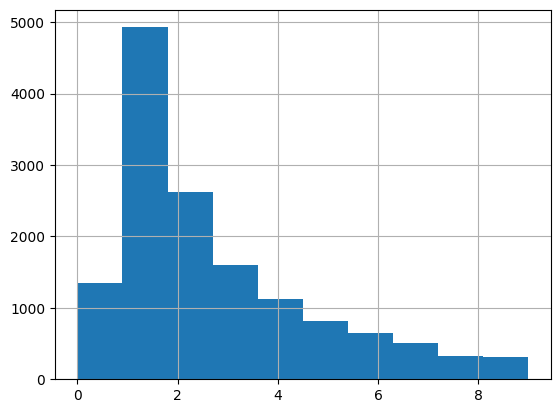

In [48]:
filtered_sabap_df.fpn[filtered_sabap_df.fpn < 10].hist()

In [49]:
## Species Count per pentad
pentad_species_count_df = filtered_sabap_df[filtered_sabap_df.fpn > 1]\
.groupby(['pentad', 'corridor_status', 'protected']).agg({'scientific_name': 'nunique'})\
.rename(columns={'scientific_name': 'species_count'})\
.reset_index()
pentad_species_count_df.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/species_count_by_pentad.csv')
pentad_species_count_df.head()

pentad corridor_status  protected  species_count
0  3255_2435    neighbouring      False             63
1  3255_2440    neighbouring      False             48
2  3255_2445    neighbouring      False             56
3  3255_2450    neighbouring      False            102
4  3255_2455    neighbouring      False             48

(array([8., 7., 8., 9., 9., 2., 0., 2., 0., 1.]),
 array([  6. ,  28.9,  51.8,  74.7,  97.6, 120.5, 143.4, 166.3, 189.2,
        212.1, 235. ]),
 <BarContainer object of 10 artists>)

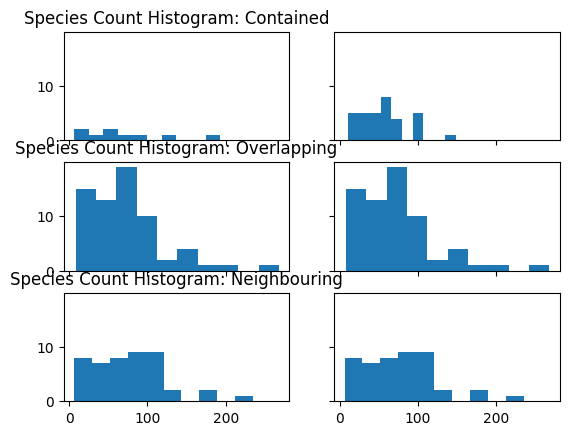

In [50]:
fig, ax = plt.subplots(3, 2, sharey=True, sharex=True)
ax[0][0].set_title('Species Count Histogram: Contained')
ax[0][0].hist(pentad_species_count_df[(pentad_species_count_df.corridor_status == 'contained') & (pentad_species_count_df.protected == True)].species_count)
ax[0][1].hist(pentad_species_count_df[(pentad_species_count_df.corridor_status == 'contained') & (pentad_species_count_df.protected == False)].species_count)
ax[1][0].set_title('Species Count Histogram: Overlapping')
ax[1][0].hist(pentad_species_count_df[pentad_species_count_df.corridor_status == 'overlapping'].species_count)
ax[1][1].hist(pentad_species_count_df[pentad_species_count_df.corridor_status == 'overlapping'].species_count)
ax[2][0].set_title('Species Count Histogram: Neighbouring')
ax[2][0].hist(pentad_species_count_df[pentad_species_count_df.corridor_status == 'neighbouring'].species_count)
ax[2][1].hist(pentad_species_count_df[pentad_species_count_df.corridor_status == 'neighbouring'].species_count)

In [51]:
## Corridor and Protected areas species count per pentad
def iqr(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    return iqr
agg_pentad_species_count_df = pentad_species_count_df.groupby(['corridor_status', 'protected']).agg({'species_count': ['min','median', 'mean', 'max', iqr, 'sum']}).reset_index()
agg_pentad_species_count_df.columns = ['corridor_status', 'protected', 'min', 'median', 'mean', 'max', 'iqr', 'sum']
agg_pentad_species_count_df.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/aggregated_species_count_by_corridor_status_protected.csv')
agg_pentad_species_count_df

corridor_status  protected  min  median        mean  max    iqr   sum
0       contained      False   11    54.0   56.848485  148  31.00  1876
1       contained       True    6    55.0   74.555556  193  57.00   671
2    neighbouring      False    6    69.0   68.714286  184  55.50  2405
3    neighbouring       True   15    86.0  101.545455  235  46.50  1117
4     overlapping      False    8    66.0   74.940000  268  46.75  3747
5     overlapping       True   11    61.5   61.625000  109  67.00   986

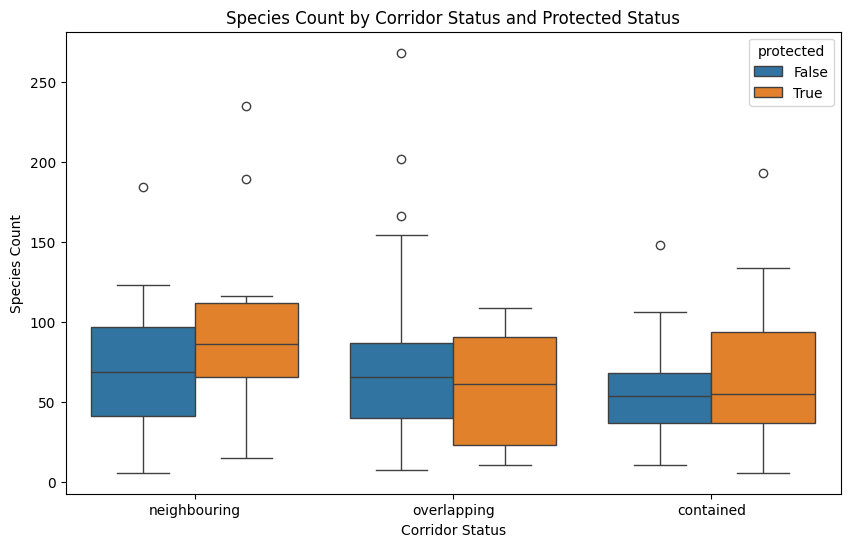

In [52]:
import seaborn as sns

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.boxplot(x='corridor_status', y='species_count', hue='protected', data=pentad_species_count_df)
plt.title('Species Count by Corridor Status and Protected Status')
plt.xlabel('Corridor Status')
plt.ylabel('Species Count')
plt.show()

In [53]:
filtered_sabap_df.groupby(['corridor_status', 'protected']).agg({'scientific_name': 'nunique'}).reset_index()

corridor_status  protected  scientific_name
0       contained      False              280
1       contained       True              297
2    neighbouring      False              309
3    neighbouring       True              309
4     overlapping      False              349
5     overlapping       True              289

In [54]:
filtered_sabap_df.scientific_name.nunique()

352

In [55]:
filtered_sabap_df.groupby(['corridor_status', 'protected', 'scientific_name']).agg({'scientific_name': 'nunique'})

scientific_name
corridor_status protected scientific_name                         
contained       False     Accipiter melanoleucus                 1
                          Accipiter minullus                     1
                          Accipiter rufiventris                  1
                          Accipiter tachiro                      1
                          Acrocephalus baeticatus                1
...                                                            ...
overlapping     True      Vanellus coronatus                     1
                          Vidua funerea                          1
                          Vidua macroura                         1
                          Zaporina flavirostra                   1
                          Zosterops virens                       1

[1833 rows x 1 columns]

## Read in Eden to Addo Species

In [56]:
e2a_species = pd.read_excel('/content/drive/MyDrive/ForTheBirds-E2A/Corridors all threatened spp list.xlsx', 'birds')\
  .rename(columns={'species.1': 'status'})\
  .drop(columns=['comment'])
e2a_species.head(40)

species          status                     name
0              Ardeotis kori              NT             Kori bustard
1            Neotis ludwigii              EN         Ludwig’s bustard
2             Neotis denhami              NT         Denham’s bustard
3    Anthropoides paradiseus              VU               Blue crane
4        Turnix hottemtottus         Endemic    Hottentot buttonquail
5             Morus capensis              EN              Cape gannet
6       Microcarbo coronatus              NT        Crowned cormorant
7     Phalacrocorax capensis              EN           Cape cormorant
8   Sagittarius serpentarius              VU            Secretarybird
9           Gyps coprotheres              EN             Cape vulture
10             Circus maurus              EN            Black harrier
11          Buteo trizonatus              NT           Forest buzzard
12         Campethera notata              NT        Knysna woodpecker
13            Falco naumanni              VU           Lesser kestrel
14           Falco anurensis  Winter migrant              Amur falcon
15         Chaetops frenatus     NT, endemic          Cape rockjumper
16      Cryptillas victorina         Endemic       Victorin’s warbler
17    Bradypterus sylvicatus     VU, endemic           Knysna warbler
18           Promerops cafer         Endemic           Cape sugarbird
19     Anthrobaphes violacea         Endemic  Orange-breasted sunbird
20           Anthus crenatus         Endemic       African rock pipit
21         Crithagra scotops         Endemic            Forest canary
22      Crithagra leucoptera     NT, endemic            Protea canary
23           Crithagra totta         Endemic              Cape siskin
24         Aquila verreauxii              NT         Verreaux's Eagle
25     Polemaetus bellicosus              EN            Martial Eagle
26              Afrotis afra              VU   Southern Black Korhaan
27             Ciconia nigra              LC              Black Stork

In [57]:
e2a_species = pd.merge(e2a_species, sabap_rr_df, how='inner', left_on='species', right_on='scientific_name').drop(columns=['scientific_name'])

In [58]:
e2a_species['corridor_status'] = e2a_species.corridor_status.apply(lambda x: 'Internal' if x == 'contained' else x.capitalize())
e2a_species['protected'] = e2a_species.protected.apply(lambda x: 'Protected' if x else 'Unprotected')
e2a_species_RR = e2a_species[['species', 'corridor_status', 'protected', 'reporting_rate']]\
  .pivot(index='species', columns=['corridor_status', 'protected'], values='reporting_rate')\
  .reset_index()\
  .fillna(0)
e2a_species_RR.columns = ['-'.join(col).strip('-') for col in e2a_species_RR.columns]

e2a_species_RR.head()

species  Internal-Unprotected  Neighbouring-Unprotected  \
0       Afrotis afra              0.091195                  0.000000   
1    Anthus crenatus              0.040881                  0.101205   
2  Aquila verreauxii              0.106918                  0.291566   
3      Ardeotis kori              0.053459                  0.028916   
4   Buteo trizonatus              0.066038                  0.040964   

   Overlapping-Unprotected  Internal-Protected  Neighbouring-Protected  \
0                 0.018129            0.000000                0.000000   
1                 0.007417            0.000000                0.007206   
2                 0.017305            0.024221                0.032826   
3                 0.008653            0.000000                0.000000   
4                 0.280181            0.335640                0.240192   

   Overlapping-Protected  
0               0.035714  
1               0.000000  
2               0.158163  
3               0.000000  
4               0.193878

In [59]:
column_order = ['Internal-Protected', 'Internal-Unprotected', 'Overlapping-Protected',
                'Overlapping-Unprotected', 'Neighbouring-Protected', 'Neighbouring-Unprotected']

e2a_species_RR['name'] = e2a_species_RR.species.apply(getCommonName)
e2a_species_RR.drop(columns=['species'], inplace=True)
e2a_species_RR = e2a_species_RR[['name'] + column_order]
e2a_species_RR.head()

name  Internal-Protected  Internal-Unprotected  \
0  Southern Black Korhaan            0.000000              0.091195   
1      African Rock Pipit            0.000000              0.040881   
2        Verreaux's Eagle            0.024221              0.106918   
3            Kori Bustard            0.000000              0.053459   
4          Forest Buzzard            0.335640              0.066038   

   Overlapping-Protected  Overlapping-Unprotected  Neighbouring-Protected  \
0               0.035714                 0.018129                0.000000   
1               0.000000                 0.007417                0.007206   
2               0.158163                 0.017305                0.032826   
3               0.000000                 0.008653                0.000000   
4               0.193878                 0.280181                0.240192   

   Neighbouring-Unprotected  
0                  0.000000  
1                  0.101205  
2                  0.291566  
3                  0.028916  
4                  0.040964

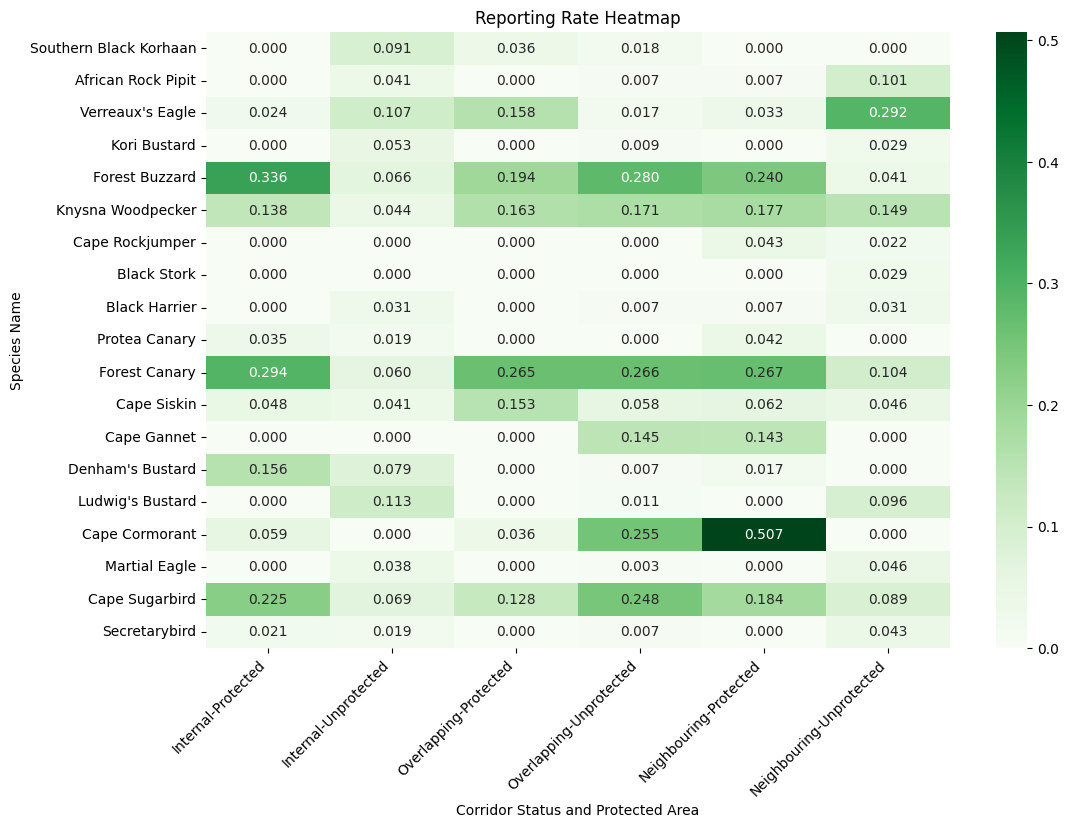

In [60]:
import seaborn as sns

# Assuming e2a_species_RR DataFrame is already created as in your provided code

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(e2a_species_RR.set_index('name'), annot=True, cmap="Greens", fmt=".3f")
plt.title('Reporting Rate Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Species Name')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()


#### Filtered Reporting rates

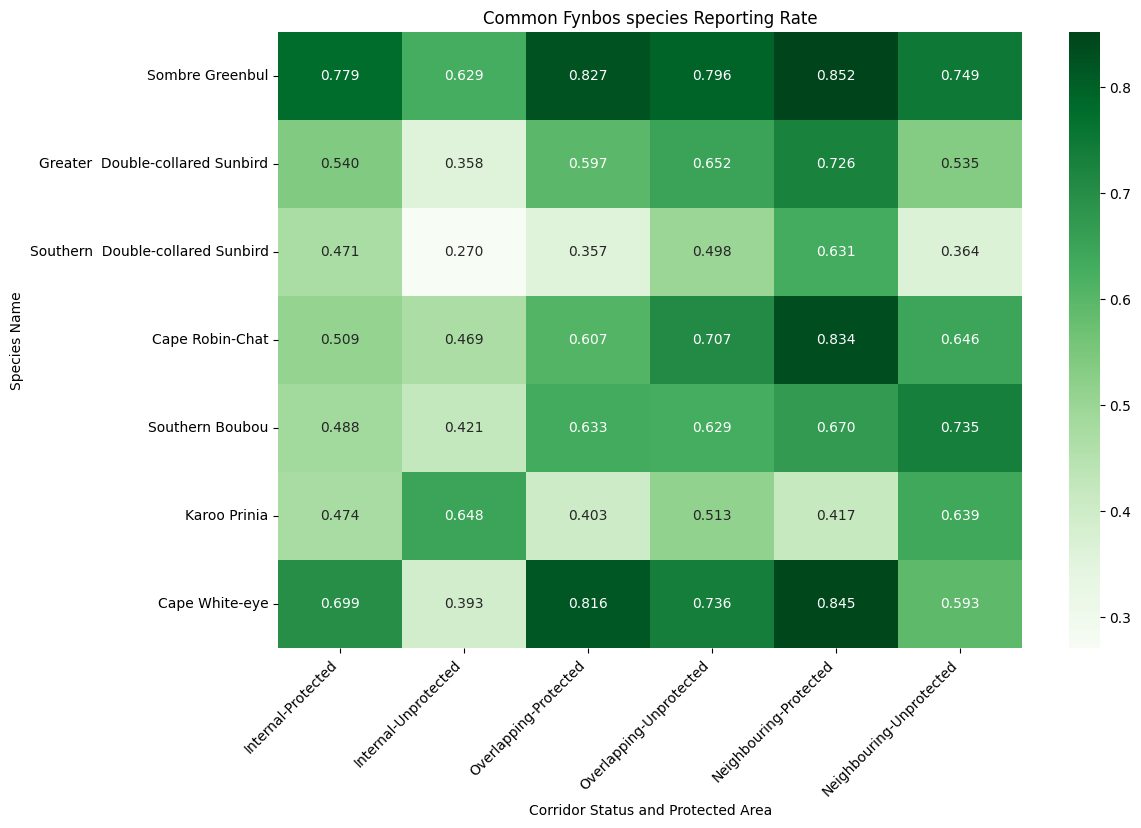

In [61]:
def getCommonName(species):
  return sabap_df[sabap_df.scientific_name == species].common_name.values[0]

def get_reporting_rate_by_corridor_protected(species_list=None):
  rr_df = sabap_rr_df.copy()
  if species_list is not None:
    rr_df = rr_df[sabap_rr_df.scientific_name.apply(lambda x: x.lower()).isin(species_list)]

  rr_df['corridor_status'] = rr_df.corridor_status.apply(lambda x: 'Internal' if x == 'contained' else x.capitalize())
  rr_df['protected'] = rr_df.protected.apply(lambda x: 'Protected' if x else 'Unprotected')
  species_RR = rr_df[['scientific_name', 'corridor_status', 'protected', 'reporting_rate']]\
    .pivot(index='scientific_name', columns=['corridor_status', 'protected'], values='reporting_rate')\
    .reset_index()\
    .fillna(0)
  if species_RR.shape[0] > 0:
    species_RR.columns = ['-'.join(col).strip('-') for col in species_RR.columns]
    species_RR['name'] = species_RR.scientific_name.apply(getCommonName)
    column_order = ['Internal-Protected', 'Internal-Unprotected', 'Overlapping-Protected',
                  'Overlapping-Unprotected', 'Neighbouring-Protected', 'Neighbouring-Unprotected']
    species_RR = species_RR[['name'] + column_order]
  return species_RR

def plot_reporting_rate_df(df, title='Reporting Rate Heatmap', cmap="Greens"):
  plt.figure(figsize=(12, 8))  # Adjust figure size as needed
  sns.heatmap(df.set_index('name'), annot=True, cmap=cmap, fmt=".3f")
  plt.title(title)
  plt.xlabel('Corridor Status and Protected Area')
  plt.ylabel('Species Name')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
  plt.show()

filtered_RR_df = get_reporting_rate_by_corridor_protected(get_species_for_group(['Common species', 'Fynbos'], 'scientific_name'))
plot_reporting_rate_df(filtered_RR_df, 'Common Fynbos species Reporting Rate')

In [62]:
grouped_rr_dfs = {group: get_reporting_rate_by_corridor_protected(get_species_for_group([group], 'scientific_name')) for group in groups}

In [63]:
grouped_rr_dfs = {group: get_reporting_rate_by_corridor_protected(get_species_for_group([group], 'scientific_name')) for group in groups}

#with pd.ExcelWriter('/content/drive/MyDrive/ForTheBirds-E2A/grouped_reporting_rates.xlsx') as writer:
#  for group, df in grouped_rr_dfs.items():
#    df.to_excel(writer, sheet_name=group, index=False)


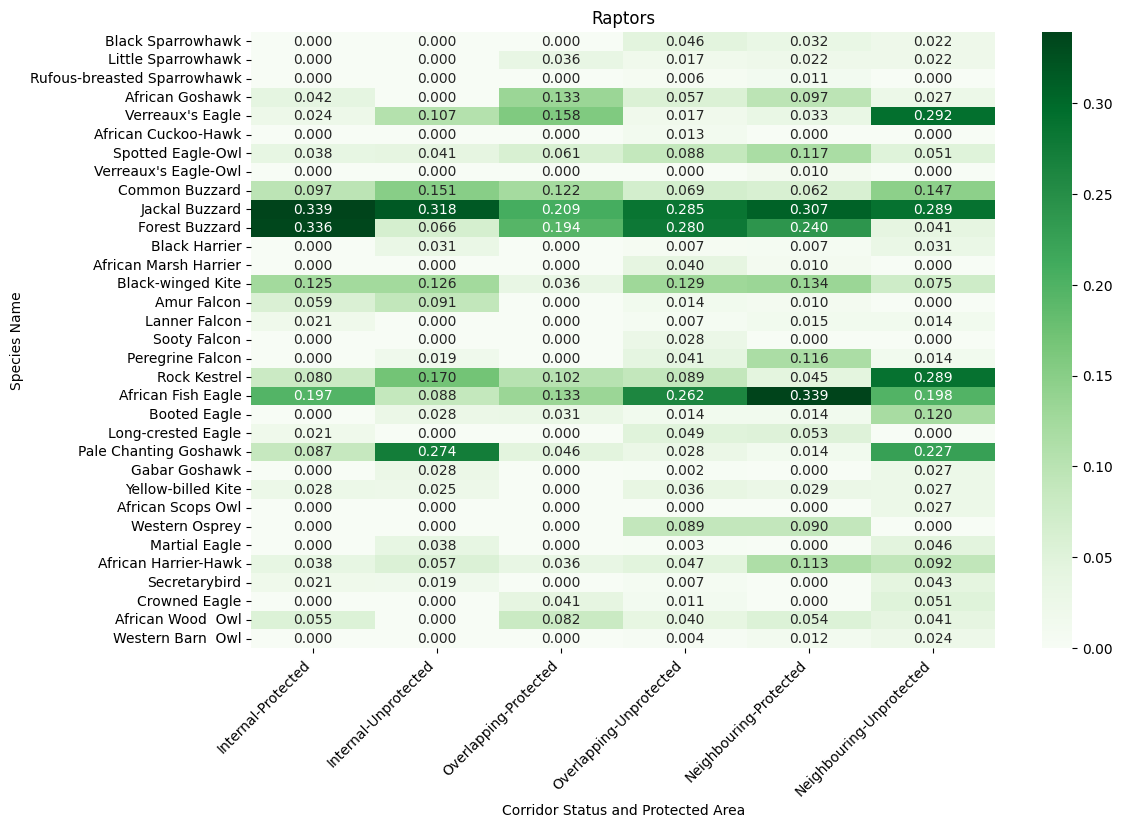

In [64]:
plot_reporting_rate_df(grouped_rr_dfs['Raptors'], 'Raptors')

#### Reporting Rates by Group

In [65]:
def get_group_rr(group):
  group_RR = filtered_sabap_df[filtered_sabap_df.scientific_name.apply(lambda x: x.lower()).isin(get_species_for_group([group], 'scientific_name'))]\
    .groupby(['corridor_status', 'protected']).agg({'fpn': 'sum', 'fp_num_cards': 'sum' }).reset_index()
  group_RR['reporting_rate'] = group_RR.fpn / group_RR.fp_num_cards
  group_RR['group'] = group
  return group_RR

In [66]:
get_group_rr('Common species')

corridor_status  protected    fpn  fp_num_cards  reporting_rate  \
0       contained      False   3746        6919.0        0.541408   
1       contained       True   3909        7016.0        0.557155   
2    neighbouring      False   6156        9652.0        0.637795   
3    neighbouring       True  22414       31994.0        0.700569   
4     overlapping      False  39132       61565.0        0.635621   
5     overlapping       True   2502        4711.0        0.531097   

            group  
0  Common species  
1  Common species  
2  Common species  
3  Common species  
4  Common species  
5  Common species

In [67]:
sabap_group_RR = pd.concat([get_group_rr(group) for group in groups])
sabap_group_RR['corridor_status'] = sabap_group_RR.corridor_status.apply(lambda x: 'Internal' if x == 'contained' else x.capitalize())
sabap_group_RR['protected'] = sabap_group_RR.protected.apply(lambda x: 'Protected' if x else 'Unprotected')
sabap_group_RR = sabap_group_RR.pivot(index='group', columns=['corridor_status', 'protected'], values='reporting_rate')\
  .reset_index()\
  .fillna(0)
sabap_group_RR.columns = ['-'.join(col).strip('-') for col in sabap_group_RR.columns]


column_order = ['Internal-Protected', 'Internal-Unprotected', 'Overlapping-Protected', 'Overlapping-Unprotected', 'Neighbouring-Protected', 'Neighbouring-Unprotected']
sabap_group_RR = sabap_group_RR[['group'] + column_order]
sabap_group_RR.head()

group  Internal-Protected  Internal-Unprotected  \
0  Coastal & Waterbirds            0.131394              0.220521   
1        Common species            0.557155              0.541408   
2                Forest            0.276084              0.274650   
3                Fynbos            0.416957              0.457865   
4                  IUCN            0.090832              0.194570   

   Overlapping-Protected  Overlapping-Unprotected  Neighbouring-Protected  \
0               0.170583                 0.200337                0.212474   
1               0.531097                 0.635621                0.700569   
2               0.360823                 0.262540                0.285139   
3               0.458566                 0.416169                0.444432   
4               0.155689                 0.098310                0.092263   

   Neighbouring-Unprotected  
0                  0.208145  
1                  0.637795  
2                  0.388626  
3                  0.539904  
4                  0.200484

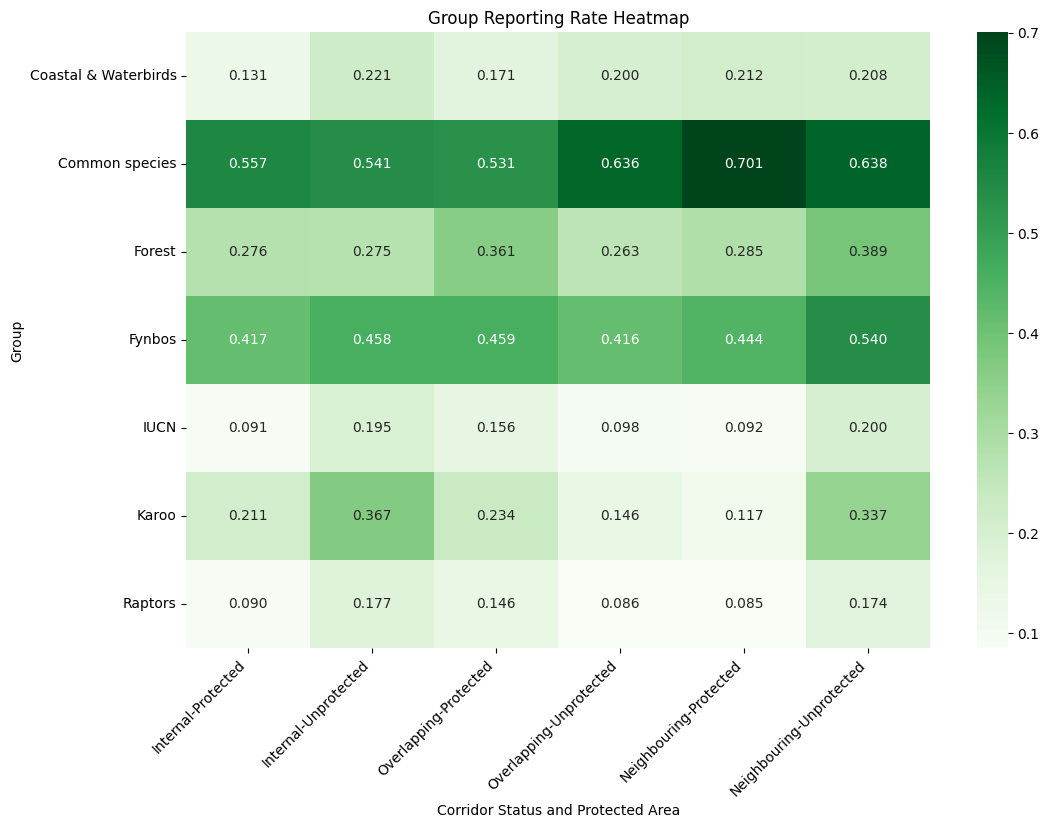

In [68]:
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(sabap_group_RR.set_index('group'), annot=True, cmap="Greens", fmt=".3f")
plt.title('Group Reporting Rate Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Group')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

## Compare Reporting Rates Between Areas
Based on the methods used in `Estimating Conservation Metrics from Atlas Data` we calculate the `index of reporting rate change`.  
$\text{Index} = \frac{\text{Reporting Rate2}}{\text{Reporting Rate1 + Reporting Rate2}} - 0.5$

The `index` is between -0.5 and 0.5 where positive values indicate that `Reporting Rate2` increased relative to `Reporting Rate1`.

For this project we compare the reporting rate for species relative to the reporting rate for _unprotected_ areas _neighbouring_ the corridor.

In [69]:
e2a_species_RR.rename(columns = {'Internal-Unprotected': 'contained-Unprotected',
       'Internal-Protected': 'contained-Protected', 'Overlapping-Unprotected': 'overlapping-Unprotected',
       'Overlapping-Protected': 'overlapping-Protected',
       'Neighbouring-Protected': 'neighbouring-Protected'})

name  contained-Protected  contained-Unprotected  \
0   Southern Black Korhaan             0.000000               0.091195   
1       African Rock Pipit             0.000000               0.040881   
2         Verreaux's Eagle             0.024221               0.106918   
3             Kori Bustard             0.000000               0.053459   
4           Forest Buzzard             0.335640               0.066038   
5        Knysna Woodpecker             0.138408               0.044025   
6          Cape Rockjumper             0.000000               0.000000   
7              Black Stork             0.000000               0.000000   
8            Black Harrier             0.000000               0.031447   
9            Protea Canary             0.034602               0.018868   
10           Forest Canary             0.294118               0.059748   
11             Cape Siskin             0.048443               0.040881   
12             Cape Gannet             0.000000               0.000000   
13        Denham's Bustard             0.155709               0.078616   
14        Ludwig's Bustard             0.000000               0.113208   
15          Cape Cormorant             0.058824               0.000000   
16           Martial Eagle             0.000000               0.037736   
17          Cape Sugarbird             0.224913               0.069182   
18           Secretarybird             0.020761               0.018868   

    overlapping-Protected  overlapping-Unprotected  neighbouring-Protected  \
0                0.035714                 0.018129                0.000000   
1                0.000000                 0.007417                0.007206   
2                0.158163                 0.017305                0.032826   
3                0.000000                 0.008653                0.000000   
4                0.193878                 0.280181                0.240192   
5                0.163265                 0.170993                0.176942   
6                0.000000                 0.000000                0.043235   
7                0.000000                 0.000000                0.000000   
8                0.000000                 0.006593                0.007206   
9                0.000000                 0.000000                0.041633   
10               0.265306                 0.265760                0.267414   
11               0.153061                 0.057684                0.061649   
12               0.000000                 0.144623                0.143315   
13               0.000000                 0.006593                0.016813   
14               0.000000                 0.011125                0.000000   
15               0.035714                 0.254635                0.506805   
16               0.000000                 0.002884                0.000000   
17               0.127551                 0.248043                0.184147   
18               0.000000                 0.007005                0.000000   

    Neighbouring-Unprotected  
0                   0.000000  
1                   0.101205  
2                   0.291566  
3                   0.028916  
4                   0.040964  
5                   0.149398  
6                   0.021687  
7                   0.028916  
8                   0.031325  
9                   0.000000  
10                  0.103614  
11                  0.045783  
12                  0.000000  
13                  0.000000  
14                  0.096386  
15                  0.000000  
16                  0.045783  
17                  0.089157  
18                  0.043373

In [70]:
## Compare reporting rates
def calculate_RR_index(rr1, rr2):
  '''
  Calculate the index of reporting rate change of rr2 relative to rr1.
  '''
  return (rr2 / (rr1 + rr2)) - 0.5

## Calculate Z scores
def calculate_z_score(rr1, rr2):
  '''
  Calculate the z score of rr2 relative to rr1.
  '''
  return (rr2 - rr1) / np.sqrt(rr1 * (1 - rr1) + rr2 * (1 - rr2))


In [71]:
pivoted_sabap_rr_df = get_pivoted_sabap_rr_df()
pivoted_sabap_rr_df.head()

scientific_name  neighbouring-Unprotected  neighbouring-Protected  \
0   Accipiter melanoleucus                  0.021687                0.032026   
1       Accipiter minullus                  0.021687                0.022418   
2    Accipiter rufiventris                  0.000000                0.011209   
3        Accipiter tachiro                  0.026506                0.096878   
4  Acrocephalus baeticatus                  0.000000                0.010408   

   overlapping-Unprotected  overlapping-Protected  contained-Protected  \
0                 0.046148               0.000000             0.000000   
1                 0.017305               0.035714             0.000000   
2                 0.005768               0.000000             0.000000   
3                 0.057272               0.132653             0.041522   
4                 0.008653               0.000000             0.000000   

   contained-Unprotected  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

In [72]:
reference_column = 'neighbouring-Unprotected'
rr_columns = [column for column in pivoted_sabap_rr_df.columns if column not in [reference_column, 'scientific_name']]

In [73]:
rr_index_dict = {col: calculate_RR_index(pivoted_sabap_rr_df['neighbouring-Unprotected'], pivoted_sabap_rr_df[col]) for col in rr_columns}
rr_index_dict['scientific_name'] = pivoted_sabap_rr_df.scientific_name

rr_index_df = pd.DataFrame(rr_index_dict)
rr_index_df['common_name'] = rr_index_df.scientific_name.apply(getCommonName)

rr_index_df.head()

neighbouring-Protected  overlapping-Unprotected  overlapping-Protected  \
0                0.096243                 0.180298              -0.500000   
1                0.008289                -0.056184               0.122189   
2                0.500000                 0.500000                    NaN   
3                0.285174                 0.183617               0.333462   
4                0.500000                 0.500000                    NaN   

   contained-Protected  contained-Unprotected          scientific_name  \
0            -0.500000                   -0.5   Accipiter melanoleucus   
1            -0.500000                   -0.5       Accipiter minullus   
2                  NaN                    NaN    Accipiter rufiventris   
3             0.110369                   -0.5        Accipiter tachiro   
4                  NaN                    NaN  Acrocephalus baeticatus   

                   common_name  
0            Black Sparrowhawk  
1           Little Sparrowhawk  
2  Rufous-breasted Sparrowhawk  
3              African Goshawk  
4    African Reed  [x] Warbler

<ipython-input-74-b73d14d5c109>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PiYG')


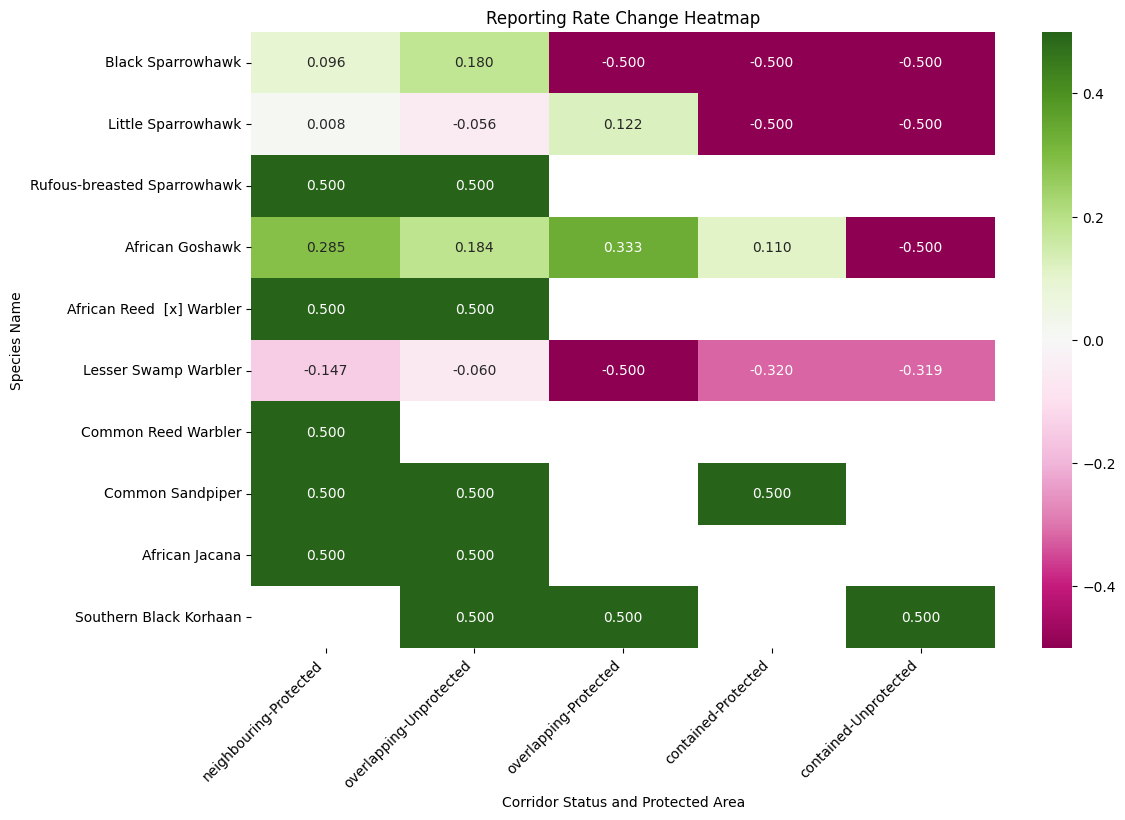

In [74]:
import seaborn as sns
import matplotlib.cm as cm

# Assuming e2a_species_RR DataFrame is already created as in your provided code

# Create the heatmap
cmap = cm.get_cmap('PiYG')
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(rr_index_df.iloc[:10].set_index('common_name').drop(columns=['scientific_name']), annot=True, cmap=cmap, fmt=".3f")
plt.title('Reporting Rate Change Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Species Name')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

## Reporting Rate Z-score
The z-score gives confidence for chagnes in abundance, a large positive value gives evidence for population increase while a large negative values gives evidence towards a population decrease. Values close to zero provide no clear evidence either way (_Lee et. al. Estimating conservation metrics from atlas data: the case of southern African endemic birds_)

$$ Z = \frac{P_2 - P_1}{\sqrt{(P(1 - P)(\frac{1}{n_1} - \frac{1}{n_2}))}}$$ Where $$P = \frac{n_1P_1 + n2P_2}{n_1 + n_2}$$

In [75]:
sabap_rr_df.head()

scientific_name corridor_status  protected  fpn  fp_num_cards  \
2  Accipiter melanoleucus    neighbouring      False    9         415.0   
3  Accipiter melanoleucus    neighbouring       True   40        1249.0   
4  Accipiter melanoleucus     overlapping      False  112        2427.0   
8      Accipiter minullus    neighbouring      False    9         415.0   
9      Accipiter minullus    neighbouring       True   28        1249.0   

   reporting_rate  
2        0.021687  
3        0.032026  
4        0.046148  
8        0.021687  
9        0.022418

In [76]:
def z_score(species, ref_corridor_status, ref_protected_status, corridor_status, protected_status):
  try:
    reference_data = sabap_rr_df[(sabap_rr_df.scientific_name == species) & (sabap_rr_df.corridor_status == ref_corridor_status) & (sabap_rr_df.protected == ref_protected_status)].iloc[0]
    other_data = sabap_rr_df[(sabap_rr_df.scientific_name == species) & (sabap_rr_df.corridor_status == corridor_status) & (sabap_rr_df.protected == protected_status)].iloc[0]
  except:
    return np.nan
  p = ((reference_data.fp_num_cards * reference_data.reporting_rate) + ( other_data.fp_num_cards * other_data.reporting_rate)) / ( reference_data.fp_num_cards + other_data.fp_num_cards)
  return (other_data.reporting_rate - reference_data.reporting_rate) / np.sqrt(p * (1 - p) * (1 / reference_data.fp_num_cards + 1 / other_data.fp_num_cards))
z_score('Anthobaphes violacea', 'neighbouring', False, 'contained', True)

3.396030947189171

In [77]:
rr_column_name_dict = {'neighbouring-False': 'neighbouring-Unprotected',
                   'neighbouring-True': 'neighbouring-Protected',
                   'overlapping-False': 'overlapping-Unprotected',
                   'overlapping-True': 'overlapping-Protected',
                   'contained-False': 'contained-Unprotected',
                   'contained-True': 'contained-Protected'}

In [78]:
z_index_dict = {}
for species in sabap_rr_df.scientific_name.unique():
  if not z_index_dict.get(species):
    z_index_dict[species] = {'scientific_name': species}
  for corridor_status in sabap_rr_df.corridor_status.unique():
    for protected_status in sabap_rr_df.protected.unique():
      z_index_dict[species][f'{corridor_status}-{protected_status}'] = z_score(species, 'neighbouring', False, corridor_status, protected_status)


In [79]:
z_index_df = pd.DataFrame(z_index_dict.values())\
  .rename(columns=rr_column_name_dict)
z_index_df['common_name'] = z_index_df.scientific_name.apply(getCommonName)
z_index_df = z_index_df[['scientific_name', 'common_name', 'contained-Unprotected', 'contained-Protected',
       'overlapping-Unprotected', 'overlapping-Protected', 'neighbouring-Unprotected', 'neighbouring-Protected']]
z_index_df.head()

scientific_name                  common_name  \
0   Accipiter melanoleucus            Black Sparrowhawk   
1       Accipiter minullus           Little Sparrowhawk   
2    Accipiter rufiventris  Rufous-breasted Sparrowhawk   
3        Accipiter tachiro              African Goshawk   
4  Acrocephalus baeticatus    African Reed  [x] Warbler   

   contained-Unprotected  contained-Protected  overlapping-Unprotected  \
0                    NaN                  NaN                 2.280783   
1                    NaN                  NaN                -0.621330   
2                    NaN                  NaN                      NaN   
3                    NaN             1.102528                 2.590380   
4                    NaN                  NaN                      NaN   

   overlapping-Protected  neighbouring-Unprotected  neighbouring-Protected  
0                    NaN                       0.0                1.079371  
1               1.013528                       0.0                0.087522  
2                    NaN                       NaN                     NaN  
3               5.134803                       0.0                4.595812  
4                    NaN                       NaN                     NaN

In [80]:
'''z_index_df = sabap_rr_df.copy()
z_index_df['protected'] = z_index_df.protected.apply(lambda x: 'Protected' if x else 'Unprotected')
z_index_df = z_index_df.pivot(index='scientific_name', columns=['corridor_status', 'protected'], values='z-index')\
  .reset_index()\
  .fillna(0)
z_index_df.columns = ['-'.join(col).strip('-') for col in z_index_df.columns]

z_index_df['common_name'] = z_index_df.scientific_name.apply(getCommonName)

relative_RR_df = z_index_df[['scientific_name', 'common_name', 'contained-Unprotected', 'contained-Protected',
       'overlapping-Unprotected', 'overlapping-Protected', 'neighbouring-Unprotected', 'neighbouring-Protected']]

z_index_df
'''

"z_index_df = sabap_rr_df.copy()\nz_index_df['protected'] = z_index_df.protected.apply(lambda x: 'Protected' if x else 'Unprotected')\nz_index_df = z_index_df.pivot(index='scientific_name', columns=['corridor_status', 'protected'], values='z-index')  .reset_index()  .fillna(0)\nz_index_df.columns = ['-'.join(col).strip('-') for col in z_index_df.columns]\n\nz_index_df['common_name'] = z_index_df.scientific_name.apply(getCommonName)\n\nrelative_RR_df = z_index_df[['scientific_name', 'common_name', 'contained-Unprotected', 'contained-Protected',\n       'overlapping-Unprotected', 'overlapping-Protected', 'neighbouring-Unprotected', 'neighbouring-Protected']]\n\nz_index_df\n"

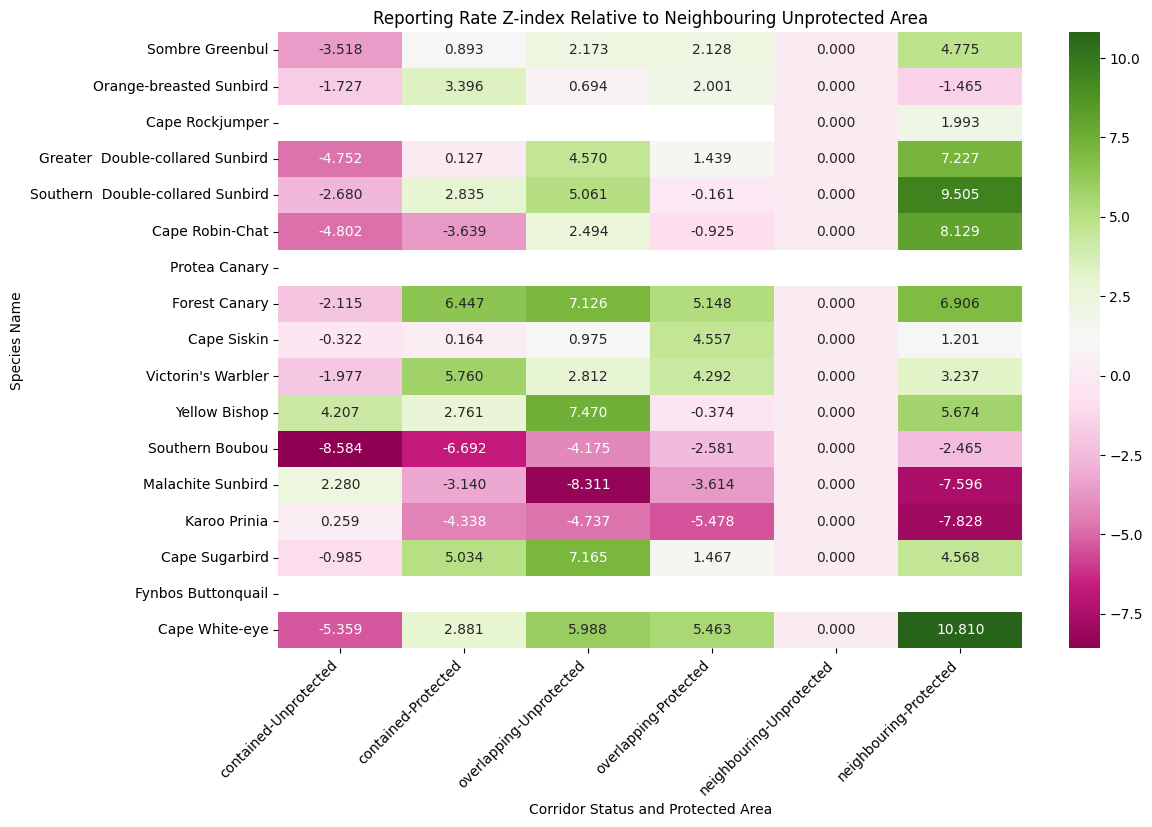

In [81]:
import seaborn as sns

# Assuming e2a_species_RR DataFrame is already created as in your provided code

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(z_index_df[z_index_df.scientific_name.isin([sp.capitalize() for sp in get_species_for_group(['Fynbos'])])].drop(columns=['scientific_name']).set_index('common_name'), annot=True, cmap=cmap, fmt=".3f")
plt.title('Reporting Rate Z-index Relative to Neighbouring Unprotected Area')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Species Name')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

In [82]:
z_index_df

scientific_name                  common_name  \
0     Accipiter melanoleucus            Black Sparrowhawk   
1         Accipiter minullus           Little Sparrowhawk   
2      Accipiter rufiventris  Rufous-breasted Sparrowhawk   
3          Accipiter tachiro              African Goshawk   
4    Acrocephalus baeticatus    African Reed  [x] Warbler   
..                       ...                          ...   
347    Vanellus melanopterus         Black-winged Lapwing   
348            Vidua funerea             Dusky Indigobird   
349           Vidua macroura            Pin-tailed Whydah   
350     Zaporina flavirostra                  Black Crake   
351         Zosterops virens               Cape White-eye   

     contained-Unprotected  contained-Protected  overlapping-Unprotected  \
0                      NaN                  NaN                 2.280783   
1                      NaN                  NaN                -0.621330   
2                      NaN                  NaN                      NaN   
3                      NaN             1.102528                 2.590380   
4                      NaN                  NaN                      NaN   
..                     ...                  ...                      ...   
347                    NaN                  NaN                      NaN   
348                    NaN                  NaN                      NaN   
349               0.095550             0.651595                 5.635461   
350              -3.209939            -1.168370                 3.592962   
351              -5.359240             2.881293                 5.987800   

     overlapping-Protected  neighbouring-Unprotected  neighbouring-Protected  
0                      NaN                       0.0                1.079371  
1                 1.013528                       0.0                0.087522  
2                      NaN                       NaN                     NaN  
3                 5.134803                       0.0                4.595812  
4                      NaN                       NaN                     NaN  
..                     ...                       ...                     ...  
347                    NaN                       NaN                     NaN  
348                    NaN                       0.0                     NaN  
349              -1.651284                       0.0                6.660810  
350                    NaN                       0.0                1.300910  
351               5.462834                       0.0               10.810269  

[352 rows x 8 columns]

## Relative Reporting Rate Comparison
[Displaying Changes in Bird Distributions between SABBAP1 and SABAP2](https://1drv.ms/x/c/c6fa6ae6a8a5c09d/EYzg-eM5l0BIs3geQPuyFNoBZlpN-Gb-qqvXxb5wmJFvkg?e=0KUurs)

$C = \frac{n_2}{n_1} = \frac{log(1-R_2)}{log(1-p)} / \frac{log(1-R_1}{log(1-p)} = \frac{log(1-R_2)}{log(1-R_1)}$

We present the results as $C - 1$ so that the metric is centered around 1.

In [83]:
pivoted_sabap_rr_df = get_pivoted_sabap_rr_df()

relative_RR_df = np.log(1-pivoted_sabap_rr_df[['contained-Unprotected', 'contained-Protected',
       'neighbouring-Unprotected', 'neighbouring-Protected',
       'overlapping-Unprotected', 'overlapping-Protected']]).apply(lambda x: (x/np.log(1-pivoted_sabap_rr_df['neighbouring-Unprotected'])) - 1)

relative_RR_df['scientific_name'] = pivoted_sabap_rr_df['scientific_name']
relative_RR_df['common_name'] = relative_RR_df.scientific_name.apply(getCommonName)

relative_RR_df = relative_RR_df[['scientific_name', 'common_name', 'contained-Unprotected', 'contained-Protected',
       'overlapping-Unprotected', 'overlapping-Protected', 'neighbouring-Unprotected', 'neighbouring-Protected']]

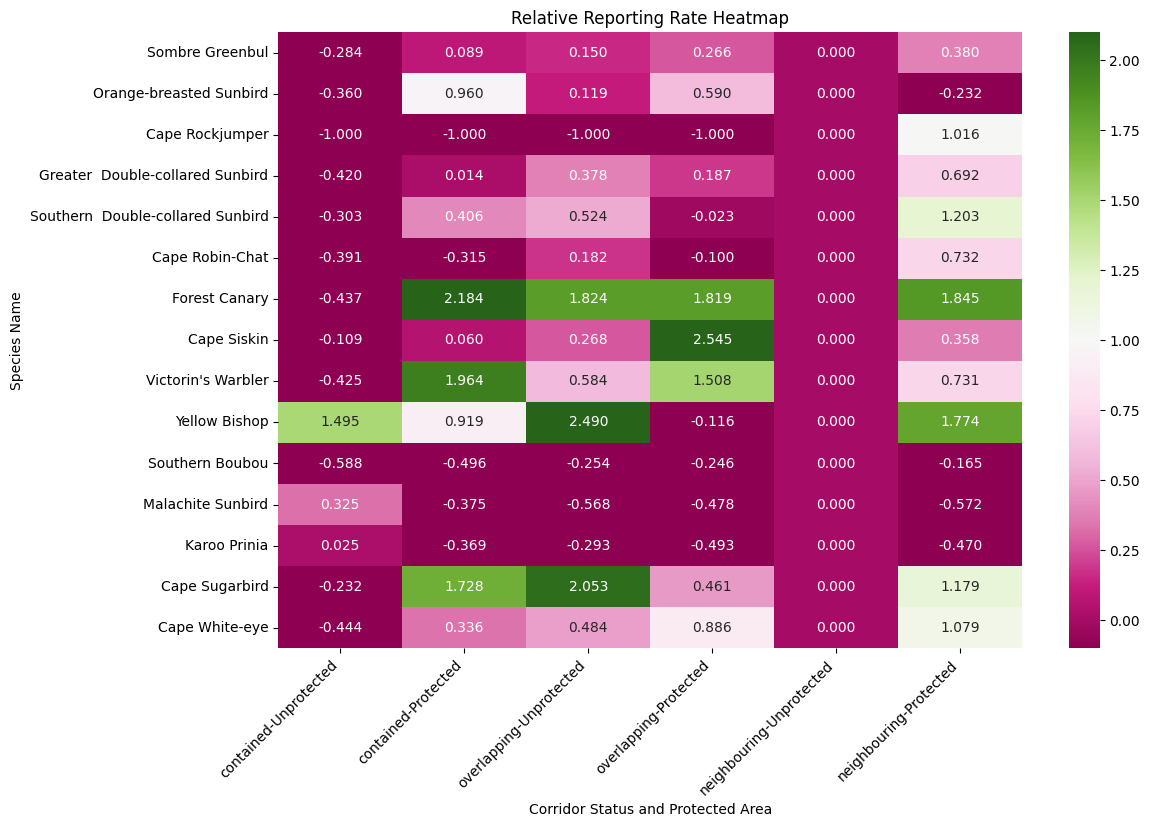

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Choose the PiYG colormap from Seaborn
cmap = sns.color_palette("PiYG", as_cmap=True)

# Assuming relative_RR_df is already defined

# Create the normalization with vcenter=1
vmin = relative_RR_df.drop(columns=['scientific_name', 'common_name']).min().min()
vmax = relative_RR_df.drop(columns=['scientific_name', 'common_name']).max().max()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

relative_RR_group = 'Fynbos';
# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(relative_RR_df[relative_RR_df.scientific_name.isin([name[0].upper() + name[1:] for name in get_species_for_group([relative_RR_group])])] \
            .dropna() \
            .set_index('common_name') \
            .drop(columns=['scientific_name']),
            annot=True,
            cmap=cmap,
            fmt=".3f",
            norm=norm)
plt.title('Relative Reporting Rate Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Species Name')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

Write to spreadsheet

In [85]:

grouped_rr_dfs = {group: relative_RR_df[relative_RR_df.scientific_name.isin([name[0].upper() + name[1:] for name in get_species_for_group([])])] for group in groups}

with pd.ExcelWriter('/content/drive/MyDrive/ForTheBirds-E2A/grouped_relative_reporting_rates.xlsx') as writer:
  for group, df in grouped_rr_dfs.items():
    df.to_excel(writer, sheet_name=group, index=False)

##Combine and order by corridor, protected status

In [86]:
#rr_index_df['name'] = rr_index_df.name.apply(lambda x: x.capitalize())

In [87]:
comparison_df = pd.merge(relative_RR_df.add_prefix('relative-RR-'), z_index_df.add_prefix('z_index-'), left_on='relative-RR-scientific_name', right_on='z_index-scientific_name')
print(comparison_df.shape)

(352, 16)


In [88]:
comparison_df = comparison_df.rename(columns={'relative-RR-common_name': 'common_name', 'relative-RR-scientific_name': 'scientific_name'}).drop(columns=['z_index-scientific_name', 'z_index-common_name'])

In [89]:
comparison_df = pd.merge(comparison_df, rr_index_df.add_prefix('index-RR-'), left_on='scientific_name', right_on='index-RR-scientific_name')
print(comparison_df.shape)

(352, 21)


In [90]:
comparison_df = comparison_df.drop(columns=['index-RR-scientific_name', 'index-RR-common_name'])

In [91]:
comparison_df

scientific_name                  common_name  \
0     Accipiter melanoleucus            Black Sparrowhawk   
1         Accipiter minullus           Little Sparrowhawk   
2      Accipiter rufiventris  Rufous-breasted Sparrowhawk   
3          Accipiter tachiro              African Goshawk   
4    Acrocephalus baeticatus    African Reed  [x] Warbler   
..                       ...                          ...   
347    Vanellus melanopterus         Black-winged Lapwing   
348            Vidua funerea             Dusky Indigobird   
349           Vidua macroura            Pin-tailed Whydah   
350     Zaporina flavirostra                  Black Crake   
351         Zosterops virens               Cape White-eye   

     relative-RR-contained-Unprotected  relative-RR-contained-Protected  \
0                            -1.000000                        -1.000000   
1                            -1.000000                        -1.000000   
2                                  NaN                              NaN   
3                            -1.000000                         0.578683   
4                                  NaN                              NaN   
..                                 ...                              ...   
347                               -inf                             -inf   
348                          -1.000000                        -1.000000   
349                           0.023991                         0.173630   
350                          -0.737053                        -0.314539   
351                          -0.444154                         0.336315   

     relative-RR-overlapping-Unprotected  relative-RR-overlapping-Protected  \
0                               1.154867                          -1.000000   
1                              -0.203808                           0.658702   
2                                   -inf                                NaN   
3                               1.195453                           4.297726   
4                                   -inf                                NaN   
..                                   ...                                ...   
347                                 -inf                                NaN   
348                            -1.000000                          -1.000000   
349                             1.475904                          -0.439221   
350                             0.964912                          -1.000000   
351                             0.483719                           0.886280   

     relative-RR-neighbouring-Unprotected  relative-RR-neighbouring-Protected  \
0                                     0.0                            0.484567   
1                                     0.0                            0.034101   
2                                     NaN                                -inf   
3                                     0.0                            2.793122   
4                                     NaN                                -inf   
..                                    ...                                 ...   
347                                   NaN                                -inf   
348                                   0.0                           -1.000000   
349                                   0.0                            1.952787   
350                                   0.0                            0.309061   
351                                   0.0                            1.078640   

     z_index-contained-Unprotected  z_index-contained-Protected  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                     1.102528   
4                              NaN                          NaN   
..                             ...                     

In [92]:
melted_df = pd.melt(
    comparison_df[['scientific_name', 'common_name'] + [col for col in comparison_df.columns if 'z_index' in col]],
    id_vars=['scientific_name', 'common_name'],  # Columns to keep as identifiers
    value_vars=[col for col in comparison_df.columns if 'z_index' in col],  # Columns to unpivot
    var_name='corridor_protected_status',  # Name for the new column containing the unpivoted column names
    value_name='z_index'  # Name for the new column containing the unpivoted values
)

In [93]:
z_vals = melted_df['z_index'].dropna()

In [94]:
print((z_vals < -0.5).sum() / z_vals.shape[0])
print((z_vals > 0.5).sum() / (z_vals > 0).sum())
print((z_vals > 3).sum() / (z_vals > 0).sum())

0.4194847020933977
0.8926940639269406
0.5273972602739726


In [95]:
RRI_vals = pd.melt(
    comparison_df[['scientific_name', 'common_name'] + [col for col in comparison_df.columns if 'index-RR' in col]],
    id_vars=['scientific_name', 'common_name'],  # Columns to keep as identifiers
    value_vars=[col for col in comparison_df.columns if 'index-RR' in col],  # Columns to unpivot
    var_name='corridor_protected_status',  # Name for the new column containing the unpivoted column names
    value_name='RRI'  # Name for the new column containing the unpivoted values
).RRI.dropna()

In [96]:
print((RRI_vals < -0.1).sum() / RRI_vals.shape[0])
print((RRI_vals > 0.1).sum() / RRI_vals.shape[0])

0.44398340248962653
0.31742738589211617


In [97]:
import scipy.stats as stats
def get_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    interval = sem * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean - interval, mean + interval

In [98]:
get_confidence_interval(melted_df['z_index'].dropna())

(-1.2512165804319002, -0.557650043811668)

In [99]:
def classify_change(relative_reporting, reporting_rate_index):
  if relative_reporting > 0.5 and reporting_rate_index > 0.1:
    return 'Increase'
  elif relative_reporting < -0.5 and reporting_rate_index < -0.1:
    return 'Decrease'
  return 'None'

def classify_confidence(z_score):
  if z_score == None or pd.isna(z_score):
    return 'N/A'
  if z_score > 3:
    return 'Very Confident Increase'
  elif z_score > 0.5:
    return 'Confident Increase'
  elif z_score >= -0.5:
    return 'Not confident'
  elif z_score >= -3:
    return 'Confident Decrease'
  else:
    return 'Very Confident Decrease'


In [100]:
pentad_types = ['contained-Unprotected',
       'contained-Protected', 'overlapping-Unprotected',
       'overlapping-Protected',
       'neighbouring-Protected', 'neighbouring-Unprotected']

pentad_type_comparision_dict = {}
for pentad_type in pentad_types[:-1]:
  temp_df = comparison_df[['scientific_name', 'common_name'] + [col for col in comparison_df.columns if pentad_type in col]]\
  .rename(columns={f'relative-RR-{pentad_type}': 'Relative Reporting Rate', f'z_index-{pentad_type}': 'Z Index', f'index-RR-{pentad_type}': 'Reporting Rate Index'})
  temp_df = temp_df[~temp_df['Reporting Rate Index'].isna()]
  temp_df['change'] = temp_df.apply(lambda row: classify_change(row['Relative Reporting Rate'], row['Reporting Rate Index']), axis=1)
  temp_df['confidence'] = temp_df.apply(lambda row: classify_confidence(row['Z Index']), axis=1)
  pentad_type_comparision_dict[pentad_type] = temp_df

In [101]:
pentad_type_comparision_dict['contained-Protected'][pentad_type_comparision_dict['contained-Protected'].common_name == 'Cape Rockjumper']

scientific_name      common_name  Relative Reporting Rate  Z Index  \
83  Chaetops frenatus  Cape Rockjumper                     -1.0      NaN   

    Reporting Rate Index    change confidence  
83                  -0.5  Decrease        N/A

In [102]:
pentad_group_dict = {}
for pentad_type, pentad_type_df in pentad_type_comparision_dict.items():
  grouped_rr_dfs = {group: pentad_type_df[pentad_type_df.scientific_name.isin([name[0].upper() + name[1:] for name in get_species_for_group([group])])] for group in groups}
  pentad_group_dict[pentad_type] = grouped_rr_dfs
  with pd.ExcelWriter(f'/content/drive/MyDrive/ForTheBirds-E2A/pentad_type_comparison/{pentad_type}_comparison.xlsx') as writer:
    for group, df in grouped_rr_dfs.items():
      df.to_excel(writer, sheet_name=group, index=False)

In [103]:
comparison_df[['relative-RR-contained-Protected', 'index-RR-contained-Protected', 'z_index-contained-Protected']].dropna().corr()

relative-RR-contained-Protected  \
relative-RR-contained-Protected                         1.000000   
index-RR-contained-Protected                            0.619931   
z_index-contained-Protected                             0.601025   

                                 index-RR-contained-Protected  \
relative-RR-contained-Protected                      0.619931   
index-RR-contained-Protected                         1.000000   
z_index-contained-Protected                          0.924346   

                                 z_index-contained-Protected  
relative-RR-contained-Protected                     0.601025  
index-RR-contained-Protected                        0.924346  
z_index-contained-Protected                         1.000000

In [104]:
comparison_df[['relative-RR-neighbouring-Protected', 'index-RR-neighbouring-Protected', 'z_index-neighbouring-Protected']].dropna().corr()

relative-RR-neighbouring-Protected  \
relative-RR-neighbouring-Protected                            1.000000   
index-RR-neighbouring-Protected                               0.427553   
z_index-neighbouring-Protected                                0.473167   

                                    index-RR-neighbouring-Protected  \
relative-RR-neighbouring-Protected                         0.427553   
index-RR-neighbouring-Protected                            1.000000   
z_index-neighbouring-Protected                             0.918115   

                                    z_index-neighbouring-Protected  
relative-RR-neighbouring-Protected                        0.473167  
index-RR-neighbouring-Protected                           0.918115  
z_index-neighbouring-Protected                            1.000000

In [105]:
comparison_df[['relative-RR-overlapping-Unprotected', 'index-RR-overlapping-Unprotected', 'z_index-overlapping-Unprotected']].dropna().corr()

relative-RR-overlapping-Unprotected  \
relative-RR-overlapping-Unprotected                             1.000000   
index-RR-overlapping-Unprotected                                0.456066   
z_index-overlapping-Unprotected                                 0.463720   

                                     index-RR-overlapping-Unprotected  \
relative-RR-overlapping-Unprotected                          0.456066   
index-RR-overlapping-Unprotected                             1.000000   
z_index-overlapping-Unprotected                              0.902069   

                                     z_index-overlapping-Unprotected  
relative-RR-overlapping-Unprotected                         0.463720  
index-RR-overlapping-Unprotected                            0.902069  
z_index-overlapping-Unprotected                             1.000000

In [106]:
pentad_type_comparision_dict.keys()

dict_keys(['contained-Unprotected', 'contained-Protected', 'overlapping-Unprotected', 'overlapping-Protected', 'neighbouring-Protected'])

In [107]:
summary_df = pentad_type_comparision_dict['contained-Protected'].copy().dropna()
summary_df['change'] = summary_df.apply(lambda row: classify_change(row['Relative Reporting Rate'], row['Reporting Rate Index']), axis=1)
summary_df['confidence'] = summary_df.apply(lambda row: classify_confidence(row['Z Index']), axis=1)

In [108]:
set(sabap_df.common_name.unique()).difference(set(filtered_sabap_df.common_name))

{'African Crake',
 'African Grass  Owl',
 'African Green Pigeon',
 'African Openbill',
 'American Golden Plover',
 'Arctic Tern',
 "Baillon's Crake",
 'Black Heron',
 'Black Swan',
 'Black-browed Albatross',
 'Black-chested Prinia',
 'Black-chested Snake Eagle',
 'Black-eared Sparrow-Lark',
 'Blue Waxbill',
 'Bronze Mannikin',
 'Brown Snake Eagle',
 'Buffy Pipit',
 'Cape Eagle-Owl',
 'Capped Wheatear',
 'Chinspot Batis',
 'Common Scimitarbill',
 "Cory's Shearwater",
 'Crowned Cormorant',
 'Damara Tern',
 'Dark-capped Bulbul',
 'Desert Cisticola',
 'Eastern Long-billed Lark',
 'Elegant Tern',
 'Eurasian Golden Oriole',
 'European Bee-eater',
 'European Honey Buzzard',
 'European Storm Petrel',
 'Great Reed Warbler',
 'Greater Kestrel',
 'Greater Sand Plover',
 'Grey Crowned Crane',
 'Grey Wagtail',
 'Groundscraper Thrush',
 'Hybrid Red/Yellow-billed  Duck',
 'Indian Yellow-nosed Albatross',
 'Karoo Chat',
 'Karoo Lark',
 'Knob-billed Duck',
 'Lesser Frigatebird',
 'Lesser Grey Shrike',


## Second Parse

In [109]:
annotated_df = pd.read_excel('/content/drive/MyDrive/ForTheBirds-E2A/contained-Protected_comparison-annotated.xlsx', sheet_name='Fynbos')
annotated_df.shape

(12, 7)

In [110]:
pentad_group_dict.get('contained-Unprotected').keys()

dict_keys(['Common species', 'Fynbos', 'Forest', 'Raptors', 'Coastal & Waterbirds', 'Karoo', 'IUCN'])

In [111]:
for group in groups:
  annotated_df = pd.read_excel('/content/drive/MyDrive/ForTheBirds-E2A/contained-Protected_comparison-annotated.xlsx', sheet_name=group)
  species_list = annotated_df.scientific_name.unique()
  for corridor_protected in pentad_group_dict.keys():
    df = pentad_group_dict[corridor_protected][group]
    print(f'{corridor_protected} - {group} {df.shape[0]}', end=' --> ')
    pentad_group_dict[corridor_protected][group] = df[df.scientific_name.isin(species_list)]
    print(pentad_group_dict[corridor_protected][group].shape[0])


contained-Unprotected - Common species 26 --> 26
contained-Protected - Common species 26 --> 26
overlapping-Unprotected - Common species 26 --> 26
overlapping-Protected - Common species 26 --> 26
neighbouring-Protected - Common species 26 --> 26
contained-Unprotected - Fynbos 16 --> 12
contained-Protected - Fynbos 16 --> 12
overlapping-Unprotected - Fynbos 15 --> 11
overlapping-Protected - Fynbos 15 --> 11
neighbouring-Protected - Fynbos 17 --> 12
contained-Unprotected - Forest 37 --> 32
contained-Protected - Forest 39 --> 34
overlapping-Unprotected - Forest 39 --> 34
overlapping-Protected - Forest 39 --> 34
neighbouring-Protected - Forest 39 --> 34
contained-Unprotected - Raptors 26 --> 26
contained-Protected - Raptors 27 --> 27
overlapping-Unprotected - Raptors 32 --> 27
overlapping-Protected - Raptors 25 --> 25
neighbouring-Protected - Raptors 31 --> 27
contained-Unprotected - Coastal & Waterbirds 30 --> 29
contained-Protected - Coastal & Waterbirds 36 --> 36
overlapping-Unprotected

In [112]:
pentad_group_dict['contained-Protected']['Forest'].head(10)

scientific_name               common_name  \
22    Andropadus importunus           Sombre Greenbul   
32         Apalis thoracica       Bar-throated Apalis   
33        Apaloderma narina             Narina Trogon   
54   Bradypterus sylvaticus            Knysna Warbler   
62         Buteo trizonatus            Forest Buzzard   
71    Camaroptera brachyura  Green-backed Camaroptera   
73        Campethera notata         Knysna Woodpecker   
80     Cercotrichas signata         Brown Scrub Robin   
91  Chlorophoneus olivaceus          Olive Bushshrike   
95     Chrysococcyx cupreus    African Emerald Cuckoo   

    Relative Reporting Rate    Z Index  Reporting Rate Index    change  \
22                 0.089354   0.892581              0.009539      None   
32                -0.388423  -5.099056             -0.060893      None   
33                 3.651921   4.635297              0.316566  Increase   
54                 0.441368   0.687533              0.089489      None   
62                 8.776844  10.440614              0.391228  Increase   
71                 0.092667   0.546083              0.019467      None   
73                -0.079332  -0.407503             -0.019091      None   
80                -1.000000        NaN             -0.500000  Decrease   
91                -0.301818  -1.772019             -0.082075      None   
95                     -inf        NaN              0.500000      None   

                 confidence  
22       Confident Increase  
32  Very Confident Decrease  
33  Very Confident Increase  
54       Confident Increase  
62  Very Confident Increase  
71       Confident Increase  
73            Not confident  
80                      N/A  
91       Confident Decrease  
95                      N/A

In [113]:
RRR_max = -1
rrr_max_values = []
for pentad_type in pentad_group_dict.keys():
    for group in pentad_group_dict.get(pentad_type):
      rrr_max_values.append(pentad_group_dict[pentad_type][group]['Relative Reporting Rate'].replace(-np.inf, np.nan).dropna().abs().max())
print(rrr_max_values)
RRR_max = np.mean(rrr_max_values)

[0.6090268447228464, 1.4950662032048072, 2.175205344682004, 1.0, 2.5169801919887216, 3.3396238930074142, 1.0, 1.8648666923670998, 2.1842369423460255, 8.776844104990627, 8.776844104990627, 28.160822154384917, 3.224302174158143, 8.776844104990627, 1.507770791292332, 2.4897471027738507, 6.859987761708945, 6.859987761708945, 74.18255064134779, 2.9683920740703456, 6.859987761708945, 1.5002291341598673, 2.5448484038947132, 7.022725438383919, 4.297726226111209, 2.227691196172707, 1.0, 4.152703410275835, 1.9498367239316403, 1.84477209054889, 9.877883989112851, 7.473542355762563, 112.26088982615934, 1.6524920759716482, 9.877883989112851]


In [114]:
from openpyxl import load_workbook
from matplotlib.colors import LinearSegmentedColormap


def format_df(df, path, sheet_name):
  # Select the columns for the table
  columns_to_display = ['scientific_name', 'common_name', 'Relative Reporting Rate', 'Z Index', 'Reporting Rate Index', 'change', 'confidence']
  df_styled = df[columns_to_display].copy()
  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)

  # Define custom colormaps for each column
  colors = [(1, 0.65, 0), (1, 1, 1), (0, 0.5, 0)]  # Orange, white, green
  cmap_name = 'orange_white_green'
  nodes = [0, 0.5, 1]  # Positions for orange, white, green

  cm = LinearSegmentedColormap.from_list(cmap_name, list(zip(nodes, colors)), N=256)

  def highlight_cells(change, confidence):
    if change == 'None' or confidence == 'Not confident':
      return
    elif change == 'Increase' and confidence == 'Very Confident Increase':
      return 'color:white;background-color:green'
    elif change == 'Increase' and confidence == 'Confident Increase':
      return 'color:black;background-color:#9ece9e'
    elif change == 'Decrease' and confidence == 'Very Confident Decrease':
      return 'color:black;background-color:orange'
    elif change == 'Decrease' and confidence == 'Confident Decrease':
      return 'color:black;background-color:#ffcc6c'

  RRI_max = df['Reporting Rate Index'].replace(-np.inf, np.nan).dropna().abs().max()
  #RRR_max = df['Relative Reporting Rate'].replace(-np.inf, np.nan).dropna().abs().max()
  Z_max = df['Z Index'].abs().max()
  print(f'RRI {-RRR_max} - {RRR_max}')

  confidence_colours = df_styled.apply(lambda row: highlight_cells(row['change'], row['confidence']), axis=1)
  return df_styled.style.background_gradient(subset=['Z Index'], cmap=cm, vmin=-Z_max, vmax=Z_max ) \
                        .background_gradient(subset=['Reporting Rate Index'], cmap=cm, vmin=-0.5, vmax=0.5) \
                        .background_gradient(subset=['Relative Reporting Rate'], cmap=cm, vmin=-1, vmax=1) \
                        .apply(lambda _: confidence_colours, subset=['change']) \
                        .apply(lambda _: confidence_colours, subset=['confidence']) \
                        .format(na_rep='') \
                        .to_excel(path, sheet_name=sheet_name)


  # Display the styled DataFrame as a table
  #display(df_styled)

      #df.to_excel(writer, sheet_name=group, index=False)
#format_df(pentad_group_dict['contained-Unprotected']['Common species'], None, None)


In [115]:
for pentad_type in pentad_group_dict.keys():
  print(pentad_type)
  with pd.ExcelWriter(f'/content/drive/MyDrive/ForTheBirds-E2A/highlighted_pentad_type_comparison/highlighted-{pentad_type}_comparison.xlsx', engine='openpyxl') as writer:
    for group in pentad_group_dict.get(pentad_type):
      formatted_df = format_df(pentad_group_dict[pentad_type][group], writer, group)

contained-Unprotected


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)


RRI -9.808923186001229 - 9.808923186001229
contained-Protected


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
overlapping-Unprotected


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
overlapping-Protected


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
neighbouring-Protected


<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_styled['Relative Reporting Rate'].replace(-np.inf, np.nan, inplace=True)
<ipython-input-114-1c309bcdb71d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229
RRI -9.808923186001229 - 9.808923186001229


## Summary Data

In [116]:
def get_data_type(column_type):
  if pd.api.types.is_string_dtype(column_type):
    return 'string'
  elif pd.api.types.is_numeric_dtype(column_type):
    return 'numeric'
  else:
    return 'other'

def comp_mean(vals):
  dtype = get_data_type(vals.dtype)
  if dtype == 'numeric':
    if vals.name == 'Relative Reporting Rate':
      return vals.replace(-np.inf, -1).apply(lambda x: min(x, 1)).mean()
    return vals.replace(-np.inf, np.nan).mean()
  elif vals.name == 'change':
    return vals.apply(lambda x: 1 if x == 'Increase' else -1 if x == 'Decrease' else 0).sum()


In [117]:
pentad_group_dict['contained-Protected']['Fynbos']['Reporting Rate Index'].mean()

0.07558956156599723

In [118]:
agg_summary_df = pd.DataFrame()
for pt in pentad_types:
  pg = pentad_group_dict.get(pt)
  if pg:
    group_summary = []
    for key in pg.keys():
      gs_data = pg.get(key).apply(comp_mean).drop(columns=['scientific_name', 'common_name'])
      gs_data['group'] = key
      gs_data['pentad_type'] = pt
      group_summary.append(gs_data);
    agg_summary_df = pd.concat([agg_summary_df, pd.DataFrame(group_summary)])

In [119]:
agg_table = agg_summary_df.pivot(columns='pentad_type', index='group', values=['change', 'Reporting Rate Index', 'Z Index', 'Relative Reporting Rate']).fillna(0)

<ipython-input-120-33dd56fb09f2>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PiYG')


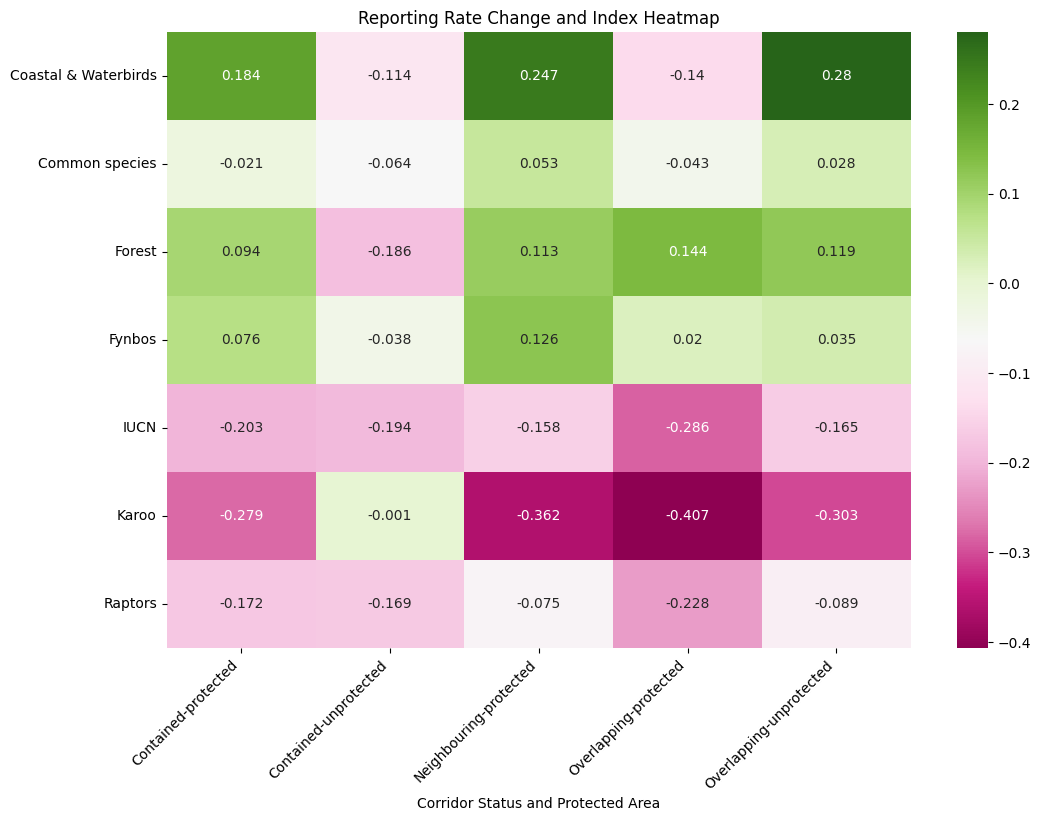

In [120]:
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

# Create the heatmap
COMP_COLUMN = 'Reporting Rate Index'
cmap = cm.get_cmap('PiYG')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    agg_table[[COMP_COLUMN]].apply(lambda x: round(x, 3)), # Select the combined column
    annot=True,
    cmap=cmap,
    fmt="",  # Use empty string for formatting to display the combined value
    cbar=True  # Hide the colorbar since values are now strings
)


plt.title('Reporting Rate Change and Index Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('')  # Updated y-axis label
xticklabels = [label.get_text()[len(COMP_COLUMN) + 1:].capitalize() for label in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45, ha='right')
plt.show()

In [121]:
agg_table['change'].astype(str) + '\n' + agg_table['Reporting Rate Index'].astype(str)

pentad_type                   contained-Protected  \
group                                               
Coastal & Waterbirds     11.0\n0.1842887000575559   
Common species        -2.0\n-0.021394929273122858   
Forest                  10.0\n0.09375359579722599   
Fynbos                   4.0\n0.07558956156599723   
IUCN                  -11.0\n-0.20278637200271038   
Karoo                 -32.0\n-0.27947918287527845   
Raptors               -12.0\n-0.17207793371835384   

pentad_type                 contained-Unprotected      neighbouring-Protected  \
group                                                                           
Coastal & Waterbirds   -4.0\n-0.11363610089947153   15.0\n0.24668911370811764   
Common species         -4.0\n-0.06417878021789282    6.0\n0.05259171062773823   
Forest                -16.0\n-0.18617620585989852    13.0\n0.1134789455000004   
Fynbos                 0.0\n-0.037948879846525015     5.0\n0.1263350718958466   
IUCN                   -9.0\n-0.19403312543059306  -8.0\n-0.15780256070245588   
Karoo                 4.0\n-0.0007365581521860151  -37.0\n-0.3615884129572849   
Raptors               -10.0\n-0.16873787346267122   -6.0\n-0.0746379974545088   

pentad_type                 overlapping-Protected      overlapping-Unprotected  
group                                                                           
Coastal & Waterbirds   -11.0\n-0.1400187780999247     20.0\n0.2800083647609782  
Common species         -2.0\n-0.04335430371947664     3.0\n0.02796593732598129  
Forest                  16.0\n0.14363444296885264     9.0\n0.11897915681629068  
Fynbos                   3.0\n0.02043738717673498    2.0\n0.034590904586157926  
IUCN                  -12.0\n-0.28580332494995797  -10.0\n-0.16513305412211685  
Karoo                   -40.0\n-0.407236828723245   -37.0\n-0.3026664218709886  
Raptors               -12.0\n-0.22781197081204754   -6.0\n-0.08859219453656983

In [122]:
agg_table['change'].apply(lambda x: 'Count: '+x.astype(str), axis=1) + agg_table['Reporting Rate Index'].apply(lambda x: '\nRI '+round(x, 2).astype(str), axis=1) + agg_table['Z Index'].apply(lambda x: '\nZ '+round(x, 2).astype(str), axis=1)

pentad_type                       contained-Protected  \
group                                                   
Coastal & Waterbirds     Count: 11.0\nRI 0.18\nZ 2.04   
Common species         Count: -2.0\nRI -0.02\nZ -1.37   
Forest                   Count: 10.0\nRI 0.09\nZ 2.53   
Fynbos                    Count: 4.0\nRI 0.08\nZ 1.97   
IUCN                   Count: -11.0\nRI -0.2\nZ -0.04   
Karoo                  Count: -32.0\nRI -0.28\nZ -4.0   
Raptors               Count: -12.0\nRI -0.17\nZ -0.74   

pentad_type                     contained-Unprotected  \
group                                                   
Coastal & Waterbirds    Count: -4.0\nRI -0.11\nZ -0.6   
Common species         Count: -4.0\nRI -0.06\nZ -3.32   
Forest                Count: -16.0\nRI -0.19\nZ -3.05   
Fynbos                  Count: 0.0\nRI -0.04\nZ -1.29   
IUCN                   Count: -9.0\nRI -0.19\nZ -1.11   
Karoo                      Count: 4.0\nRI -0.0\nZ 0.1   
Raptors               Count: -10.0\nRI -0.17\nZ -0.97   

pentad_type                    neighbouring-Protected  \
group                                                   
Coastal & Waterbirds     Count: 15.0\nRI 0.25\nZ 8.55   
Common species            Count: 6.0\nRI 0.05\nZ 4.69   
Forest                   Count: 13.0\nRI 0.11\nZ 3.85   
Fynbos                    Count: 5.0\nRI 0.13\nZ 3.58   
IUCN                   Count: -8.0\nRI -0.16\nZ -2.19   
Karoo                 Count: -37.0\nRI -0.36\nZ -9.19   
Raptors                Count: -6.0\nRI -0.07\nZ -1.41   

pentad_type                     overlapping-Protected  \
group                                                   
Coastal & Waterbirds  Count: -11.0\nRI -0.14\nZ -1.15   
Common species         Count: -2.0\nRI -0.04\nZ -1.91   
Forest                    Count: 16.0\nRI 0.14\nZ 3.0   
Fynbos                    Count: 3.0\nRI 0.02\nZ 1.38   
IUCN                  Count: -12.0\nRI -0.29\nZ -0.06   
Karoo                 Count: -40.0\nRI -0.41\nZ -5.14   
Raptors               Count: -12.0\nRI -0.23\nZ -0.84   

pentad_type                   overlapping-Unprotected  
group                                                  
Coastal & Waterbirds     Count: 20.0\nRI 0.28\nZ 7.36  
Common species            Count: 3.0\nRI 0.03\nZ 1.97  
Forest                    Count: 9.0\nRI 0.12\nZ 2.74  
Fynbos                    Count: 2.0\nRI 0.03\nZ 3.01  
IUCN                  Count: -10.0\nRI -0.17\nZ -4.56  
Karoo                 Count: -37.0\nRI -0.3\nZ -10.16  
Raptors                Count: -6.0\nRI -0.09\nZ -3.39

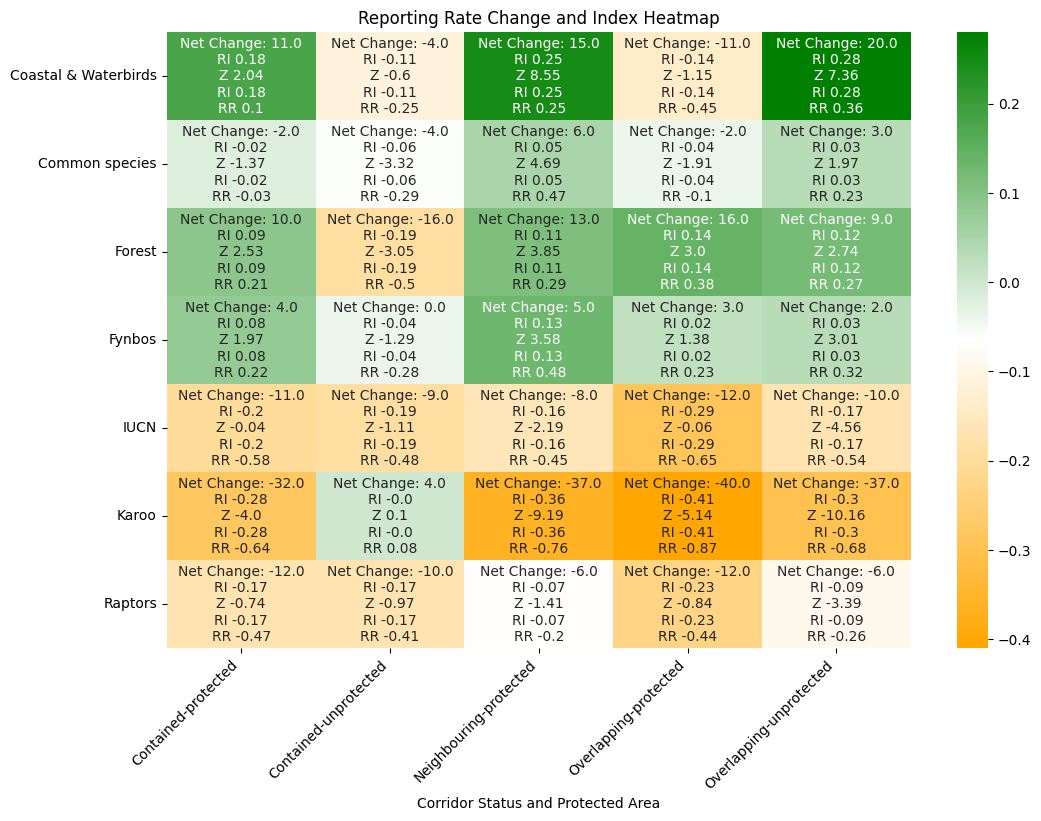

In [123]:
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

colors = [(1, 0.65, 0), (1, 1, 1), (0, 0.5, 0)]  # Orange, white, green
cmap_name = 'orange_white_green'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
combined_agg_table = agg_table['change'].apply(lambda x: 'Net Change: '+x.astype(str), axis=1) + agg_table['Reporting Rate Index'].apply(lambda x: '\nRI '+round(x, 2).astype(str), axis=1) + agg_table['Z Index'].apply(lambda x: '\nZ '+round(x, 2).astype(str), axis=1) + agg_table['Reporting Rate Index'].apply(lambda x: '\nRI '+round(x, 2).astype(str), axis=1) + agg_table['Relative Reporting Rate'].apply(lambda x: '\nRR '+round(x, 2).astype(str), axis=1)

# Create the heatmap
COMP_COLUMN = 'Reporting Rate Index'
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    agg_table[[COMP_COLUMN]].apply(lambda x: round(x, 2)), # Select the combined column
    annot=combined_agg_table,
    cmap=cm,
    fmt="",  # Use empty string for formatting to display the combined value
    cbar=True  # Hide the colorbar since values are now strings
)


plt.title('Reporting Rate Change and Index Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('')  # Updated y-axis label
xticklabels = [label.get_text()[len(COMP_COLUMN) + 1:].capitalize() for label in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45, ha='right')
plt.show()

In [133]:
agg_table[agg_table.index != 'Common species']

change                        \
pentad_type          contained-Protected contained-Unprotected   
group                                                            
Coastal & Waterbirds                11.0                  -4.0   
Forest                              10.0                 -16.0   
Fynbos                               4.0                   0.0   
IUCN                               -11.0                  -9.0   
Karoo                              -32.0                   4.0   
Raptors                            -12.0                 -10.0   

                                                                   \
pentad_type          neighbouring-Protected overlapping-Protected   
group                                                               
Coastal & Waterbirds                   15.0                 -11.0   
Forest                                 13.0                  16.0   
Fynbos                                  5.0                   3.0   
IUCN                                   -8.0                 -12.0   
Karoo                                 -37.0                 -40.0   
Raptors                                -6.0                 -12.0   

                                             Reporting Rate Index  \
pentad_type          overlapping-Unprotected  contained-Protected   
group                                                               
Coastal & Waterbirds                    20.0             0.184289   
Forest                                   9.0             0.093754   
Fynbos                                   2.0             0.075590   
IUCN                                   -10.0            -0.202786   
Karoo                                  -37.0            -0.279479   
Raptors                                 -6.0            -0.172078   

                                                                   \
pentad_type          contained-Unprotected neighbouring-Protected   
group                                                               
Coastal & Waterbirds             -0.113636               0.246689   
Forest                           -0.186176               0.113479   
Fynbos                           -0.037949               0.126335   
IUCN                             -0.194033              -0.157803   
Karoo                            -0.000737              -0.361588   
Raptors                          -0.168738              -0.074638   

                                                                    \
pentad_type          overlapping-Protected overlapping-Unprotected   
group                                                                
Coastal & Waterbirds             -0.140019                0.280008   
Forest                            0.143634                0.118979   
Fynbos                            0.020437                0.034591   
IUCN                             -0.285803               -0.165133   
Karoo                            -0.407237               -0.302666   
Raptors                          -0.227812               -0.088592   

                                 Z Index                        \
pentad_type          contained-Protected contained-Unprotected   
group                                                            
Coastal & Waterbirds            2.042443             -0.600627   
Forest                          2.533077             -3.048612   
Fynbos                          1.974527             -1.287340   
IUCN                           -0.042435             -1.114356   
Karoo                          -4.004327              0.103029   
Raptors                        -0.737822             -0.968985   

                                                                   \
pentad_type          neighbouring-Protected overlapping-Protected   
group                                                               
Coastal & Waterbirds               8.548052             -1.146545   
Forest                             3.846724              2.999389   
Fy

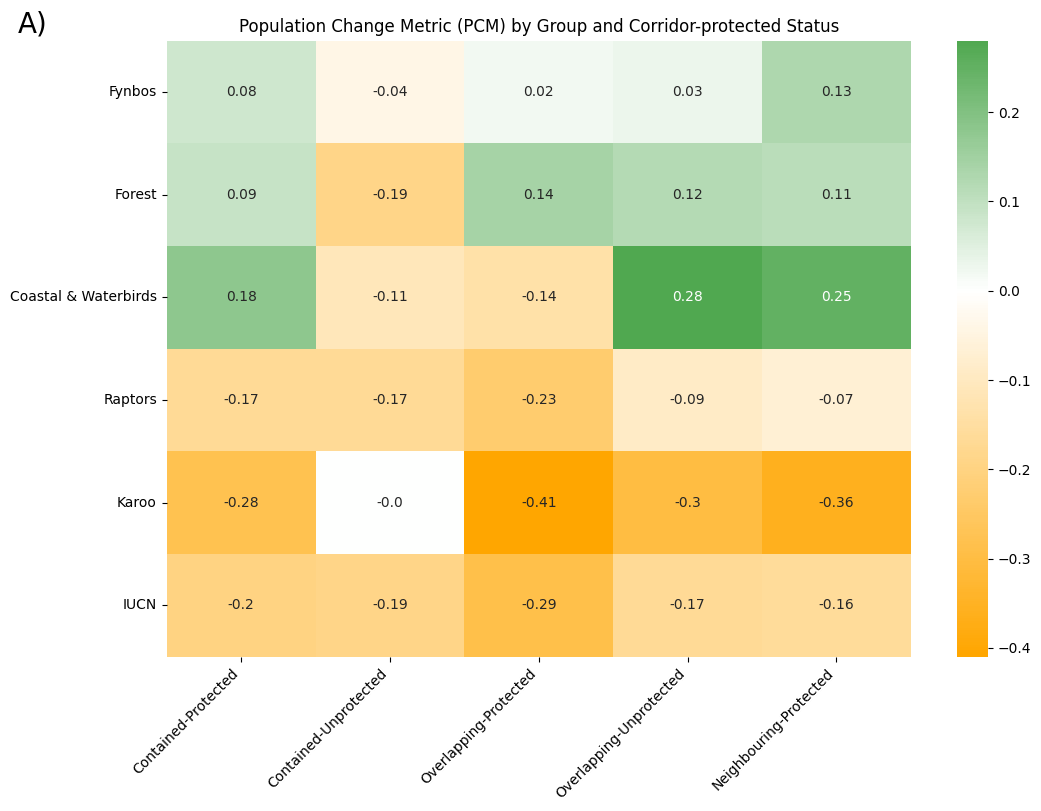

In [153]:
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def capitalize_label(label):
  return '-'.join([l.capitalize() for l in label.split('-')])

colors = [(1, 0.65, 0), (1, 1, 1), (0, 0.5, 0)]  # Orange, white, green
cmap_name = 'orange_white_green'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
combined_agg_table = agg_table['change'].apply(lambda x: 'Net Change: '+x.astype(str), axis=1) + agg_table['Reporting Rate Index'].apply(lambda x: '\nRI '+round(x, 2).astype(str), axis=1) + agg_table['Z Index'].apply(lambda x: '\nZ '+round(x, 2).astype(str), axis=1) + agg_table['Reporting Rate Index'].apply(lambda x: '\nRI '+round(x, 2).astype(str), axis=1) + agg_table['Relative Reporting Rate'].apply(lambda x: '\nRR '+round(x, 2).astype(str), axis=1)

# Create the heatmap
COMP_COLUMN =  'Reporting Rate Index'  #'Z Index' #'Reporting Rate Index' #'Relative Reporting Rate'
data = agg_table[agg_table.index != 'Common species'][[COMP_COLUMN]].apply(lambda x: round(x, 2)) # Select the combined column
data = data[[(COMP_COLUMN,     'contained-Protected'),
            (COMP_COLUMN,   'contained-Unprotected'),
            (COMP_COLUMN,   'overlapping-Protected'),
            (COMP_COLUMN, 'overlapping-Unprotected'),
            (COMP_COLUMN,  'neighbouring-Protected')]]

custom_order = ['Fynbos', 'Forest', 'Coastal & Waterbirds', 'Raptors', 'Karoo', 'IUCN']
data = data.sort_index(key=lambda x: [custom_order.index(i) if i in custom_order else len(custom_order) for i in x])

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    data,
    annot=data,
    cmap=cm,
    center=0,
    fmt="",  # Use empty string for formatting to display the combined value
    cbar=True  # Hide the colorbar since values are now strings
)

title_dict = {
    'Reporting Rate Index': 'Population Change Metric (PCM)',
    'Z Index': 'Z-score (Z)',
    'Relative Reporting Rate': 'Relative Reporting Rate (C)'
}

plt.text(-0.2, 1.05, 'A)', transform=plt.gca().transAxes, fontsize=20, va='top')
plt.title(f'{title_dict.get(COMP_COLUMN)} by Group and Corridor-protected Status')
plt.xlabel('')#('Corridor Status and Protected Area')
plt.ylabel('')  # Updated y-axis label
xticklabels = [capitalize_label(label.get_text()[len(COMP_COLUMN) + 1:]) for label in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.savefig(f'/content/drive/MyDrive/ForTheBirds-E2A/images/group_{COMP_COLUMN}.png')
plt.show()


In [149]:
custom_order = ['Fynbos', 'Forest', 'Coastal & Waterbirds', 'Raptors', 'Karoo', 'IUCN']
data.sort_index(key=lambda x: [custom_order.index(i) if i in custom_order else len(custom_order) for i in x])

Relative Reporting Rate                        \
pentad_type              contained-Protected contained-Unprotected   
group                                                                
Fynbos                                  0.22                 -0.28   
Forest                                  0.21                 -0.50   
Coastal & Waterbirds                    0.10                 -0.25   
Raptors                                -0.47                 -0.41   
Karoo                                  -0.64                  0.08   
IUCN                                   -0.58                 -0.48   

                                                                    \
pentad_type          overlapping-Protected overlapping-Unprotected   
group                                                                
Fynbos                                0.23                    0.32   
Forest                                0.38                    0.27   
Coastal & Waterbirds                 -0.45                    0.36   
Raptors                              -0.44                   -0.26   
Karoo                                -0.87                   -0.68   
IUCN                                 -0.65                   -0.54   

                                             
pentad_type          neighbouring-Protected  
group                                        
Fynbos                                 0.48  
Forest                                 0.29  
Coastal & Waterbirds                   0.25  
Raptors                               -0.20  
Karoo                                 -0.76  
IUCN                                  -0.45

In [ ]:
relative_RR_df[relative_RR_df.columns[2:]].max()

contained-Unprotected         6.042958
contained-Protected          28.160822
overlapping-Unprotected      74.182551
overlapping-Protected         7.022725
neighbouring-Unprotected      0.000000
neighbouring-Protected      112.260890
dtype: float64

In [ ]:
relative_RR_df.replace(-np.inf, np.nan).dropna()[relative_RR_df.columns[2:]].min()

contained-Unprotected      -1.0
contained-Protected        -1.0
overlapping-Unprotected    -1.0
overlapping-Protected      -1.0
neighbouring-Unprotected    0.0
neighbouring-Protected     -1.0
dtype: float64

In [ ]:
relative_RR_df['contained-Protected'].replace(-np.inf, -1).apply(lambda x: min(x, 1)).mean()

-0.32454859710954154

In [ ]:
relative_RR_df['contained-Protected'].apply(lambda x: min(x, 1))

0     -1.000000
1     -1.000000
2           NaN
3      0.578683
4           NaN
         ...   
347        -inf
348   -1.000000
349    0.173630
350   -0.314539
351    0.336315
Name: contained-Protected, Length: 352, dtype: float64